Student: Nozomu Nakanishi
Student Id: 2020264
Github:
CA 2 - Big Data / Advanced Data Analytics - 17/11/23

- Importing the necessary libraries for the practical part.

In [1]:
from pyspark.sql import SparkSession
import sparknlp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import to_date, to_timestamp, unix_timestamp, from_unixtime
from pyspark.sql import functions as F
from pyspark.sql.functions import col, explode, expr, lit, regexp_replace, lower, split, size, length
from pyspark.sql.functions import when, corr, round
from pyspark import StorageLevel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import RobustScaler, PowerTransformer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
import itertools
import pmdarima as pm
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

- To avoid repetitions when commenting the code, codes such as .show() will not be commented. Because, more than 50% of them were used just for the Spark "lazyness" (to trigger the command).  

### Initializing Spark sessiong and Importing the dataset ProjectTweets.

In [2]:
# Initialize Spark Session with recommended settings for Spark NLP
spark = SparkSession.builder \
    .appName("ProjectTweets") \
    .master("local[*]") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrator", "com.johnsnowlabs.nlp.serialization.SparkNLPKryoRegistrator") \
    .getOrCreate()

- The manipulation of the dataset were possible on both MongoDB and Cassandra, however during the processing stage numeros serializations and pickled errors were being generated. Therefore, the project will be carried out importing the dataset from the local machine. 
- Notebooks attempting the processing and timeseries stages are located in the GitHub repository provided. 

In [3]:
# Defines the schema of the CSV file (ProjectTweets.csv) and adjust the field names and types for the dataframe.
tweetSchema = StructType([
    StructField("sequence", IntegerType(), True),
    StructField("ids", StringType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
])

# Imports the dataset in csv format.
df = spark.read.csv("file:///home/hduser/Desktop/CA2/ProjectTweets.csv", header=False, schema=tweetSchema)

In [4]:
df.show(5, truncate=False)

+--------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|sequence|ids       |date                        |flag    |user           |text                                                                                                               |
+--------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0       |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|1       |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|2       |1467810917|Mon Apr 06 22:19:53

In [5]:
# Number of rows
num_rows = df.count()

# Number of columns
num_columns = len(df.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

The DataFrame shape is: (1600000, 6)


- As presented in the .show, the dataframe called df has 6 columns and 1.6 millions of observations. 

In [6]:
# Prints the df schema. 
df.printSchema()

# Which shows that the types of the data are ones set in previous steps.

root
 |-- sequence: integer (nullable = true)
 |-- ids: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



- It was observable that the dates have a pacific day time (PDT) and the present notebook it has a different time zone, thus setting the time zone to PDT.

In [7]:
# Sets the time zone to PDT, the same as the date column.
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

In [8]:
# Creating a new column where the date has a format that is better to perform analysis and models.
# Features like the day of the week and time zone are not necessary. 
date_format = "EEE MMM dd HH:mm:ss zzz yyyy"
# Parses the date e creates a new column dates with a shorter format, but with the necessary data. 
df = df.withColumn("dates", from_unixtime(unix_timestamp("date", date_format)))
df.show()

+--------+----------+--------------------+--------+---------------+--------------------+-------------------+
|sequence|       ids|                date|    flag|           user|                text|              dates|
+--------+----------+--------------------+--------+---------------+--------------------+-------------------+
|       0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|2009-04-06 22:19:45|
|       1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|2009-04-06 22:19:49|
|       2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|2009-04-06 22:19:53|
|       3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|2009-04-06 22:19:57|
|       4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|2009-04-06 22:19:57|
|       5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|2009-04-06 22:20:00|
|       6|146781159

### MISSING VALUES (TEXT COLUMN) AND DUPLICATES (TWITTER ID)

- The missing values will be searched through the tweets column, since the first objective is to extract the sentiment. 
- The duplicates will be searched through the twitter Id column, since is a unique identifier for each tweet, any duplicates will be further removed. 

In [9]:
# Find the count of missing values in the 'text' column
missing_values_count = df.filter(df.text.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

# To find duplicates based on the 'ids' column
duplicates_count = df.groupBy('ids').count().filter("`count` > 1").count()
print(f"Number of duplicate ids: {duplicates_count}")

Number of missing values in 'text' column: 0


Number of duplicate ids: 1685


In [10]:
# To find duplicates based on the 'ids' column
duplicates_count = df.groupBy('ids').count().filter("`count` > 1").count()
print(f"Number of duplicate ids: {duplicates_count}")

Number of duplicate ids: 1685


In [11]:
df = df.dropDuplicates(['ids'])

# Now you can check the count of the DataFrame to ensure duplicates have been removed.
print(f"Count after dropping duplicates: {df.count()}")

Count after dropping duplicates: 1598315


- No presence of empty cells in the dataframe, however 1685 duplicates were found and removed. Reducing the number of observations to 1,598,315.

- Next step will drop columns that do not have purpose in the analysis and extraction.

In [12]:
df = df.drop("date", "ids", "user", "flag")
df.show()

+--------+--------------------+-------------------+
|sequence|                text|              dates|
+--------+--------------------+-------------------+
|       0|@switchfoot http:...|2009-04-06 22:19:45|
|       1|is upset that he ...|2009-04-06 22:19:49|
|       3|my whole body fee...|2009-04-06 22:19:57|
|       6|         Need a hug |2009-04-06 22:20:03|
|       8|@Tatiana_K nope t...|2009-04-06 22:20:05|
|       9|@twittera que me ...|2009-04-06 22:20:09|
|      12|@caregiving I cou...|2009-04-06 22:20:19|
|      15|@iamjazzyfizzle I...|2009-04-06 22:20:20|
|      18|@LettyA ahh ive a...|2009-04-06 22:20:31|
|      20|@alydesigns i was...|2009-04-06 22:20:37|
|      21|one of my friend ...|2009-04-06 22:20:38|
|      29|Meh... Almost Lov...|2009-04-06 22:21:04|
|      31|@alielayus I want...|2009-04-06 22:21:07|
|      33|@julieebaby awe i...|2009-04-06 22:21:11|
|      34|@HumpNinja I cry ...|2009-04-06 22:21:21|
|      35|ok I'm sick and s...|2009-04-06 22:21:20|
|      36|@c

- The column sequence was kept because it contains the original sequence of the dataframe, so in case of any shuffling the original sequence can be called. 

- Next stage will be performed the pre-processing of the tweets.  

# Pre-processing of the tweets and sentiment extraction.

- This step is separeted by two main lines of code, the first will normalized the tweets, by removing url, tags, mentions and character which has no meaning in sentiment extraction. The second is a pipeline from sparkNLP to generate and extract data that it is required to sentiment analysis over time and forecasting. 

- Both of the approaches will attempt to leverage the potential of Spark tools, such as the regex and the Natural Language Processing (NLP) tool, where it has numerous options from the simplest detection to deep learning. 

In [13]:
# Remove URLs
df = df.withColumn("text", F.regexp_replace(F.col("text"), "http(s)?://[^\\s]+", ""))

# Remove HTML tags
df = df.withColumn("text", F.regexp_replace(F.col("text"), "<[^>]+>", ""))

# Remove mentions (i.e., @username)
df = df.withColumn("text", F.regexp_replace(F.col("text"), "@\\w+", ""))

# Convert to lowercase
df = df.withColumn('text', lower(df['text']))

# Remove numbers from the "text" column
df = df.withColumn('text', regexp_replace(df['text'], r'\d+', ''))

# Reduce excessive characters (more than two of the same in a row)
df = df.withColumn('text', regexp_replace('text', r'(.)\1{2,}', r'\1\1'))

# Remove punctuation
df = df.withColumn('text', regexp_replace(df['text'], r"[^\w\s]", ""))

df.select("text").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------+
|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                                    |
|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah                  |
| i dived many times for the ball managed to save   the rest go out of bounds                                                 |
|my whole body feels itchy and like its on fire                                                                               |
|need a hug                                                                                             

In [14]:
# Counts the entries with URLs.
url_count = df.filter(F.col("text").rlike("http(s)?://([\\w-]+\\.)+[\\w-]+(/[\\w- ./?%&=]*)?")).count()

# Counts the entries with HTML tags.
html_tags_count = df.filter(F.col("text").rlike("<[^>]+>")).count()

# Counts the entries with mentions (@username).
mentions_count = df.filter(F.col("text").rlike("@\\w+")).count()

print(f"Number of entries with URLs: {url_count}")
print(f"Number of entries with HTML tags: {html_tags_count}")
print(f"Number of entries with mentions: {mentions_count}")

Number of entries with URLs: 0
Number of entries with HTML tags: 0
Number of entries with mentions: 0


In [15]:
# Find the count of missing values in the 'text' column
missing_values_count = df.filter(df.text.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

Number of missing values in 'text' column: 0


The last few lines of code shows that: 
- The final format is satisfatory to apply NLP techniques; 
- No mentions, tags, html were found after normalization;
- Also, no missing values were generated by the regex; 

### Natural Language Processing with SparkNLP library. 

The library chosen is based on a few factors. First, to extract the semtiment VADER approach , which is considered to be appropriate for social media content was attempt. However, erros related to out of memory and serialization led to the discard of the technique. And with many other options sparkNLP presented to be a good option, for memory efficiency and richness of NLP tasks. 
Overvall the choice of the library relies on: 
- It was built on top of Spark, thus is highly scalable and it is an appropriate choice for big dataframes, which is the case of this project, with more than a million tweets.
- It possess a vast number of operations, from the simplest to neural networks. The operations that are necessary to extract the data required can be achieved with only one library (memory effiency and consistency during transformations). 
- Pipeline, tasks can be perfomed with an optimized workflows through pipelines, reducing the number of codes to be called. 
- Pre-trained models, the library has models that are trained already that can be applied to other dataframes, in case of this project are, spell checker, word embeddings and sentiment extraction techniques will be used. 

The codes and usage for the techniques and models were obtain through the SparkNLP documentation / annotadors. <br>
1.  https://sparknlp.org/docs/en/concepts <br>
2.  https://sparknlp.org/docs/en/annotators

The pipeline is composed by eight operations: 

1. The first is to transform the tweets into a document format that is going to be required in the next stages;

2. Not only to maintain the original context, many other operations in the pipeline needs the text at a sentence level to perform at best, in the present case, the tokenizer onwards is mainly using this format;

- Language detector using a pre-trained model was performed, however it did not yield good results, removing the code from the pipeline.

3. Tokenization of the tweets, the next techniques required that the text inputs are separeted;

4. In social media content is known to have many type of misspellings and the sparkNLP provides a few options to correct it <b>(1)</b>. The pre-trained chosen model is NorvigSweeting model, although the choice was made due to memory constrains.<b>(2)</b> 
- The first pre-trained approach attempted was the Context Spell Checker, a noisy channel model spell algorithm. However, the machine used for project resulted in running of out memory, the machine is not powerful enough to perform this model. 

The attempts of the following stages were performed back and forth until a workflow was accepted by the machine capabilities. To avoid repetition, the steps 5, 6 and 7 were chosen by the machine capabilities, although the experiments of each one will be listed below. 

5. Embedding the words using the method Glove (100 dimensions) to vectorize the tokens. One of the simplest model provided by the annotators. Numerous trials were performed using different techniques, roBERta, BERT, Universal Sentence Encoder (USC), but all returned the same error, out of memory. In addition, the choice of the embedding technique suffered influence of the next steps.

6. Sentiment is extract at a sentence level, therefore the word embedding need to be to be transformed.

7. The model that will predict the sentiment of the tweets is the sentimentDL using the pre-trained model on the Glove imdb (movies reviews). 
- The model is not the ideal for this dataframe, however, models like the sentimentdl_use_twitter were attempted however it required a type of embedding that the present machine could not perform the UCS. <b>(3)</b> Therefore, the extraction and embedding approaches were chosen to aim the most suitable for text and accepted by the machine memory. 
- The threshold set to the model is 0.7, meaning that values above this will be labeled as positives and the values below the -0.7 will be considered negatives. Neutral sentiments will be labeled when the score falls between the two values.

<b>(1):</b>https://medium.com/john-snow-labs/easily-correcting-typos-and-spelling-errors-on-texts-with-spark-nlp-and-python-1cffa3250f57 <br>
<b>(2):</b>https://sparknlp.org/docs/en/annotators#contextspellchecker <br>
<b>(3):</b>https://sparknlp.org/2021/01/18/sentimentdl_use_twitter_en.html

In [16]:
from sparknlp.annotator import * # Imports the annotators (the techniques that will applied in the pipeline)
from sparknlp.base import *

# 1. Document assembler.
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# 2. Sentence detector.
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# 3. Tokenize the tweets.
tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

# 4. Context-aware Spell Checker
spellChecker = NorvigSweetingModel.pretrained() \
    .setInputCols(["token"]) \
    .setOutputCol("corrected")

# 5. Word Embedding with Glove (100 dimentions).
embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
    .setInputCols(["sentence", "corrected"]) \
    .setOutputCol("embeddings")

# 6. Convert word embeddings to sentence embeddings, which is required for the sentiment extraction model. 
sentence_embeddings = SentenceEmbeddings() \
    .setInputCols(["sentence", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

# 7. Use the SentimentDLModel compatible with GloVe embeddings (Threshold set 0.6 is also the default value)
sentiment_detector = SentimentDLModel.pretrained('sentimentdl_glove_imdb', 'en') \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("sentiment") \
    .setThreshold(0.7) \

# 8. Finisher to convert annotations (the corrected tweets in token format and the sentiments) to DataFrame columns.
finisher = Finisher() \
    .setInputCols(["sentiment"]) \
    .setOutputCols(["sentiment_result"]) \
    .setIncludeMetadata(True)

# Final pipeline with all stages
pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    spellChecker,
    embeddings,
    sentence_embeddings,
    sentiment_detector,
    finisher  
])

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[ / ]spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[ / ]Download done! Loading the resource.


[ — ]

[ \ ]

[ | ]

[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ — ]glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ]Download done! Loading the resource.
[OK!]
sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[ / ]sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[ — ]Download done! Loading the resource.


[ \ ]

[ / ]

2023-11-14 00:29:11.950997: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[OK!]


- The pipeline will be applied and the results will be the addition of the columns with the corrected text (token format) and the sentiment (score and polarity) along with the metadata.
<br><br>
- The persist is being called in this line of code for a few reasons: 
1. Jupyter getting slow and memory issues starting to appear after the pipeline.
2. The dataframe suffered transformations up to this point and it will have more additional tasks after the pipeline, therefore to avoid the calculation of the workflow the technique will be applied. Note: cache was also attempted but the memory itself was not enough, thus sharing the dataframe between disk and memory.

In [17]:
# Apply the pipeline to the DataFrame
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)
df.persist(StorageLevel.MEMORY_AND_DISK)
df.count()
# Display the results
df.show(truncate=False)

+--------+--------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------+-------------------------------------------------------+
|sequence|text                                                                                                                            |dates              |sentiment_result|sentiment_result_metadata                              |
+--------+--------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------+-------------------------------------------------------+
|68      |  not forever11 see you soon                                                                                                    |2009-04-06 22:23:28|[pos]           |[{sentence, 0}, {pos, 0.99131984}, {neg, 0.008680178}] |
|159     |oh  just got all my macheist  apps  sweet didnt get the es

After the pipeline a new data preparation has to be performed, because the results are not in the desired format or any operations is needed to use the data. 

The next steps will be performe due to:

- The sentiment column with the metadata does not have the overall score of the sentiment, just the sum of positive and negative score, thus the next line of code will calculate the final score. 

- The code will create a new column with dates in a new format timestamp (Year-Month-Day) in order to perform aggregations in a later stage. 

- The sentiment scores have too many decimals, which may increase the need of computational resources, thus the decimals after the whole number will be reduced to 3.

- Dropping columns that are not necessary anymore. 

In [18]:
df = df.withColumn("daily_records", to_date(col("dates"), 'yyyy-MM-dd'))

# Convert the dates column from string to timestamp
df = df.withColumn("dates", to_timestamp(col("dates"), 'yyyy-MM-dd HH:mm:ss'))
df.select("dates", "daily_records").show()

+-------------------+-------------+
|              dates|daily_records|
+-------------------+-------------+
|2009-04-06 22:23:28|   2009-04-06|
|2009-04-06 22:30:50|   2009-04-06|
|2009-04-06 22:52:59|   2009-04-06|
|2009-04-06 23:01:14|   2009-04-06|
|2009-04-06 23:03:23|   2009-04-06|
|2009-04-06 23:18:16|   2009-04-06|
|2009-04-06 23:18:59|   2009-04-06|
|2009-04-06 23:23:03|   2009-04-06|
|2009-04-06 23:23:07|   2009-04-06|
|2009-04-06 23:32:47|   2009-04-06|
|2009-04-06 23:35:06|   2009-04-06|
|2009-04-06 23:35:10|   2009-04-06|
|2009-04-06 23:44:03|   2009-04-06|
|2009-04-06 23:53:53|   2009-04-06|
|2009-04-07 00:16:16|   2009-04-07|
|2009-04-07 00:32:13|   2009-04-07|
|2009-04-07 00:32:27|   2009-04-07|
|2009-04-07 00:38:06|   2009-04-07|
|2009-04-07 00:38:17|   2009-04-07|
|2009-04-07 00:48:22|   2009-04-07|
+-------------------+-------------+
only showing top 20 rows



In [19]:
# Extract positive and negative scores
df = df.withColumn("positive_score", expr("filter(sentiment_result_metadata, x -> x._1 == 'pos')[0]._2"))
df = df.withColumn("negative_score", expr("filter(sentiment_result_metadata, x -> x._1 == 'neg')[0]._2"))

# Calculate sentiment score by subtracting the negative score from the positive score
df = df.withColumn("sentiment_score", col("positive_score") - col("negative_score"))

# Show the resulting DataFrame with sentiment score
df.select("text", "sentiment_result", "sentiment_score").show()

+--------------------+----------------+-------------------+
|                text|sentiment_result|    sentiment_score|
+--------------------+----------------+-------------------+
|  not forever11 s...|           [pos]|        0.982639662|
|oh  just got all ...|       [neutral]|0.03298530000000005|
|crap i need more ...|           [neg]|       -0.994555624|
|i had a horrible ...|           [neg]|      -0.9991101201|
| hells to the no ...|           [pos]|         0.47807643|
|  the mint ones a...|           [pos]|          0.8148422|
| shut up you11i a...|           [pos]|       0.9971133619|
|i dont like lukew...|           [pos]|   0.99999982835387|
|got a great first...|           [pos]| 0.9999966465818001|
|would love to str...|           [pos]|    0.9999845035235|
|jade is looking f...|           [pos]|     0.999978249646|
| tweetfinder hate...|           [pos]|0.43312576999999997|
|im still at work ...|           [neg]|       -0.977214159|
|   is at  followers |           [pos]| 

In [20]:
# Round the sentiment_score to 3 decimal places
# Reducing the precision to three decimals can keep the precision and at the same making the column more memory friendly.
df = df.withColumn("sentiment_score", round(df["sentiment_score"], 3))

In [21]:
df = df.withColumn("sentiment_result", explode(df.sentiment_result))
# Show the resulting DataFrame
df.show()

+--------+--------------------+-------------------+----------------+-------------------------+-------------+--------------+--------------+---------------+
|sequence|                text|              dates|sentiment_result|sentiment_result_metadata|daily_records|positive_score|negative_score|sentiment_score|
+--------+--------------------+-------------------+----------------+-------------------------+-------------+--------------+--------------+---------------+
|      68|  not forever11 s...|2009-04-06 22:23:28|             pos|     [{sentence, 0}, {...|   2009-04-06|    0.99131984|   0.008680178|          0.983|
|     159|oh  just got all ...|2009-04-06 22:30:50|         neutral|     [{sentence, 0}, {...|   2009-04-06|    0.51649266|    0.48350736|          0.033|
|     493|crap i need more ...|2009-04-06 22:52:59|             neg|     [{sentence, 0}, {...|   2009-04-06|   0.002722176|     0.9972778|         -0.995|
|     598|i had a horrible ...|2009-04-06 23:01:14|             neg|  

In [22]:
df = df.drop("sentiment_result_metadata", "positive_score", "negative_score")
df.show()

+--------+--------------------+-------------------+----------------+-------------+---------------+
|sequence|                text|              dates|sentiment_result|daily_records|sentiment_score|
+--------+--------------------+-------------------+----------------+-------------+---------------+
|      68|  not forever11 s...|2009-04-06 22:23:28|             pos|   2009-04-06|          0.983|
|     159|oh  just got all ...|2009-04-06 22:30:50|         neutral|   2009-04-06|          0.033|
|     493|crap i need more ...|2009-04-06 22:52:59|             neg|   2009-04-06|         -0.995|
|     598|i had a horrible ...|2009-04-06 23:01:14|             neg|   2009-04-06|         -0.999|
|  800822| hells to the no ...|2009-04-06 23:03:23|             pos|   2009-04-06|          0.478|
|  801106|  the mint ones a...|2009-04-06 23:18:16|             pos|   2009-04-06|          0.815|
|     868| shut up you11i a...|2009-04-06 23:18:59|             pos|   2009-04-06|          0.997|
|     918|

The commands of the previous cells presents that all the operations were succesfull. 

- A new table daily_records was successfull created. 
- The overall sentiment of the tweet also successfull extracted and calculated. 
- The last .show(), points that the reduction of long decimal numbers was successful.
- Also showing that the drop worked and the dataframe is ready to begin a exploratory analysis and followed by the time series analysis.

### Exploratory Data Analysis of tweets and scores.

In the exploratory section will be performed focusing on three main features of the dataframe, the time points (dates), the tweets and the sentiment scores.

In [23]:
# Temporal Distribution: Count tweets per day
tweets_per_day = df.groupby('daily_records').count()
tweets_per_day.show()

2023-11-14 02:08:56,977 WARN memory.MemoryStore: Not enough space to cache rdd_144_15 in memory! (computed 2.3 MiB so far)
2023-11-14 02:09:06,130 WARN memory.MemoryStore: Not enough space to cache rdd_144_99 in memory! (computed 2.3 MiB so far)
2023-11-14 02:09:07,704 WARN memory.MemoryStore: Not enough space to cache rdd_144_113 in memory! (computed 2.3 MiB so far)
2023-11-14 02:09:11,361 WARN memory.MemoryStore: Not enough space to cache rdd_144_149 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:12,253 WARN memory.MemoryStore: Not enough space to cache rdd_144_161 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:12,846 WARN memory.MemoryStore: Not enough space to cache rdd_144_171 in memory! (computed 2.4 MiB so far)


+-------------+------+
|daily_records| count|
+-------------+------+
|   2009-05-13|  4055|
|   2009-06-25| 19663|
|   2009-05-01|  7691|
|   2009-06-15|109461|
|   2009-06-07| 96011|
|   2009-05-03| 35214|
|   2009-06-24|  6285|
|   2009-05-11|  4178|
|   2009-05-27|   837|
|   2009-04-17|  3076|
|   2009-06-20| 45282|
|   2009-04-20| 18405|
|   2009-06-22| 11986|
|   2009-04-21|  8572|
|   2009-05-23|   169|
|   2009-05-25|   169|
|   2009-06-01|109860|
|   2009-04-19| 27394|
|   2009-05-18| 36368|
|   2009-06-21| 16327|
+-------------+------+
only showing top 20 rows



2023-11-14 02:09:20,924 WARN memory.MemoryStore: Not enough space to cache rdd_144_77 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:21,135 WARN memory.MemoryStore: Not enough space to cache rdd_144_80 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:21,422 WARN memory.MemoryStore: Not enough space to cache rdd_144_85 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:22,519 WARN memory.MemoryStore: Not enough space to cache rdd_144_101 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:22,568 WARN memory.MemoryStore: Not enough space to cache rdd_144_102 in memory! (computed 2.3 MiB so far)
2023-11-14 02:09:22,988 WARN memory.MemoryStore: Not enough space to cache rdd_144_108 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:24,921 WARN memory.MemoryStore: Not enough space to cache rdd_144_143 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:26,623 WARN memory.MemoryStore: Not enough space to cache rdd_144_160 in memory! (computed 2.4 MiB so far)
2023-11-14 

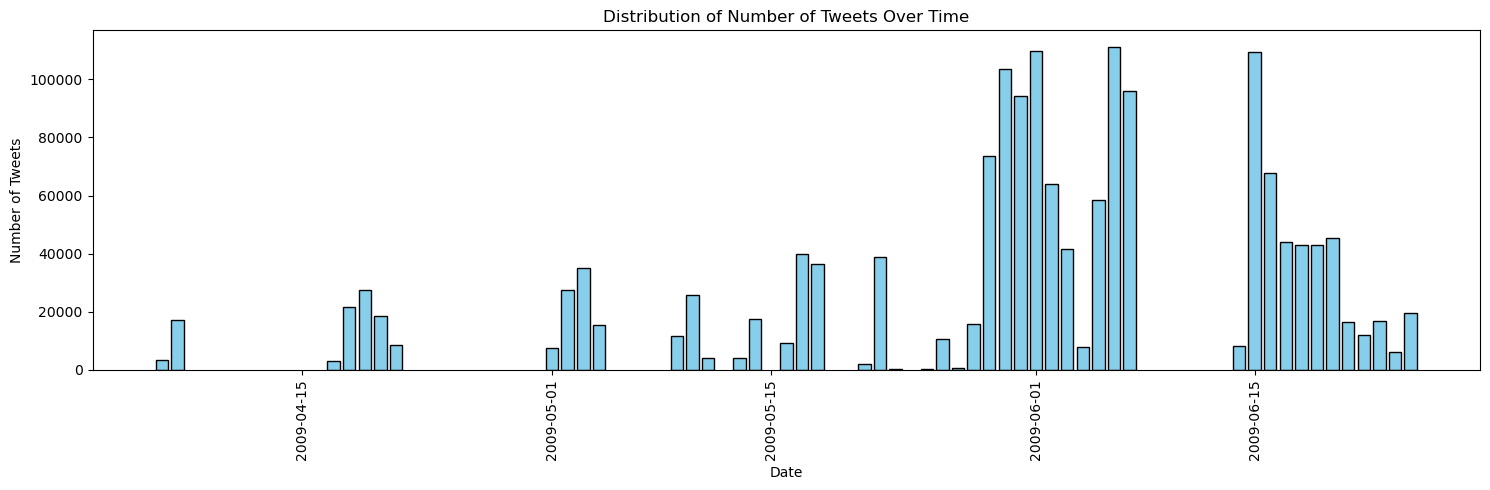

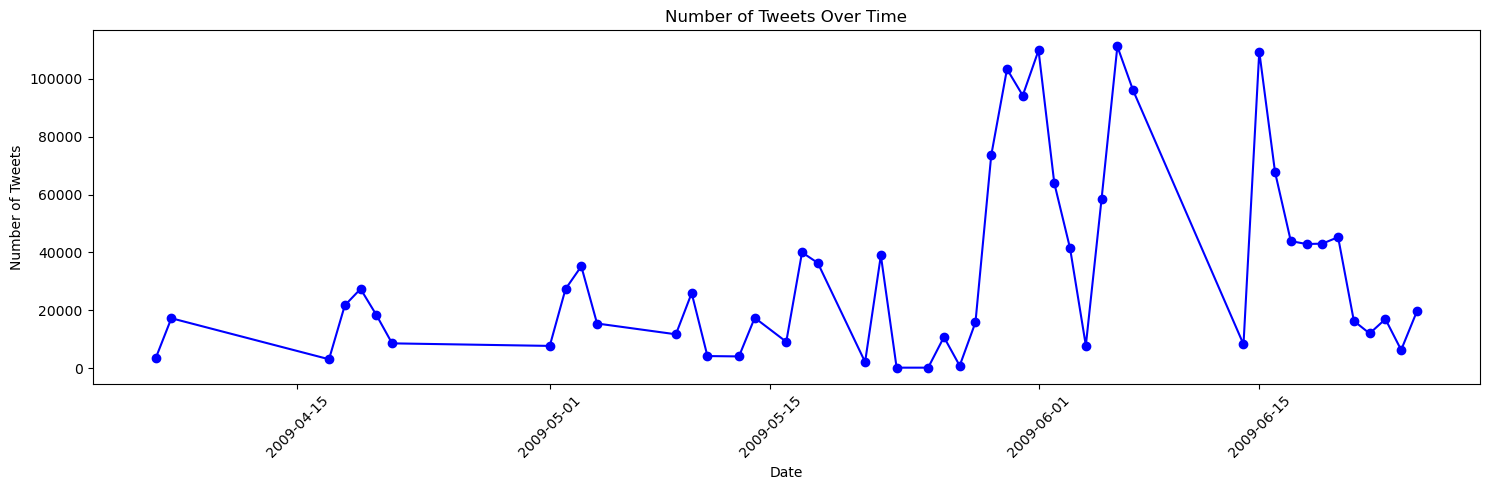

In [24]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
tweets_per_day_pd = tweets_per_day.toPandas()

# Sort the DataFrame based on the date for the line plot
tweets_per_day_pd.sort_values('daily_records', inplace=True)

# Plot the bar chart
plt.figure(figsize=(15, 5))
plt.bar(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)  # Rotate the dates for better readability if there are many bars
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Line plot of the number of tweets over time
plt.figure(figsize=(15, 5))
plt.plot(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], marker='o', linestyle='-', color='blue')
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


- The previous code shows that the number of tweets per day are not equal, presenting high variability between the days recorded (not normally distributed, based on the histogram). 
- Both the plots (bar and line) presents how the volume of tweets changes overtime, where the end of May until the middle of June have the highest number of tweets collected (more than 200K tweets).

Throughout the project it was noticed some gaps between the recorded days. Therefore, the next codes will identify what days are missing the recorded data range.

In [25]:
# Number of rows
num_rows = tweets_per_day.count()

# Number of columns
num_columns = len(tweets_per_day.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

2023-11-14 02:09:31,761 WARN memory.MemoryStore: Not enough space to cache rdd_144_0 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:38,004 WARN memory.MemoryStore: Not enough space to cache rdd_144_98 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:38,839 WARN memory.MemoryStore: Not enough space to cache rdd_144_110 in memory! (computed 2.4 MiB so far)


The DataFrame shape is: (48, 2)


In [26]:
# Find the Minimum and Maximum Dates
min_date = tweets_per_day.agg(F.min("daily_records")).collect()[0][0]
max_date = tweets_per_day.agg(F.max("daily_records")).collect()[0][0]

# Calculate the Date Range
date_range = (max_date - min_date).days

# Print the Date Range
print(f"The range of days is: {date_range} days")

2023-11-14 02:09:45,412 WARN memory.MemoryStore: Not enough space to cache rdd_144_7 in memory! (computed 2.3 MiB so far)
2023-11-14 02:09:45,496 WARN memory.MemoryStore: Not enough space to cache rdd_144_8 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:45,520 WARN memory.MemoryStore: Not enough space to cache rdd_144_9 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:45,607 WARN memory.MemoryStore: Not enough space to cache rdd_144_10 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:45,636 WARN memory.MemoryStore: Not enough space to cache rdd_144_11 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:45,770 WARN memory.MemoryStore: Not enough space to cache rdd_144_12 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:45,820 WARN memory.MemoryStore: Not enough space to cache rdd_144_13 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:45,876 WARN memory.MemoryStore: Not enough space to cache rdd_144_14 in memory! (computed 2.3 MiB so far)
2023-11-14 02:09:46

2023-11-14 02:09:55,131 WARN memory.MemoryStore: Not enough space to cache rdd_144_33 in memory! (computed 2.3 MiB so far)
2023-11-14 02:09:55,193 WARN memory.MemoryStore: Not enough space to cache rdd_144_34 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:55,204 WARN memory.MemoryStore: Not enough space to cache rdd_144_35 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:55,258 WARN memory.MemoryStore: Not enough space to cache rdd_144_36 in memory! (computed 2.3 MiB so far)
2023-11-14 02:09:55,267 WARN memory.MemoryStore: Not enough space to cache rdd_144_37 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:55,319 WARN memory.MemoryStore: Not enough space to cache rdd_144_38 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:55,327 WARN memory.MemoryStore: Not enough space to cache rdd_144_39 in memory! (computed 2.4 MiB so far)
2023-11-14 02:09:55,383 WARN memory.MemoryStore: Not enough space to cache rdd_144_40 in memory! (computed 2.3 MiB so far)
2023-11-14 02:09

The range of days is: 80 days


# ADD A CODE TO FIND THE START AND THE END.
According to the previous codes:
- The range is from <b>XXXXx to YYYY</b>
- The total recorded days is 80.
- The number of days recorded is 48, thus the total missing days in the range is 32 days.

After identifying the missing days, which will have to imputed in order to perform time-series analysis, however a further EDA will help to decide a better strategy to address this gaps. 

In [27]:
# Add a new column 'text_length' that contains the length of the 'text' column.
df = df.withColumn("text_length", length(df.text))

# Add a new column 'word_count' that contains the number of words in the 'text' column.
df = df.withColumn("word_count", size(split(df.text, "\s+")))

df.select("text_length", "word_count").show()

+-----------+----------+
|text_length|word_count|
+-----------+----------+
|         28|         6|
|        123|        24|
|         29|         7|
|         82|        16|
|         37|        10|
|        119|        24|
|        111|        22|
|         29|         6|
|         57|        13|
|        118|        20|
|         34|         8|
|         91|        16|
|        128|        22|
|         17|         4|
|        124|        23|
|         67|        16|
|         37|         9|
|         60|        10|
|         56|        11|
|        102|        23|
+-----------+----------+
only showing top 20 rows



In [28]:
df.describe(["word_count", "text_length"]).show()

2023-11-14 02:10:03,038 WARN memory.MemoryStore: Not enough space to cache rdd_144_7 in memory! (computed 2.3 MiB so far)
2023-11-14 02:10:03,300 WARN memory.MemoryStore: Not enough space to cache rdd_144_8 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:03,574 WARN memory.MemoryStore: Not enough space to cache rdd_144_9 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:03,705 WARN memory.MemoryStore: Not enough space to cache rdd_144_10 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:03,917 WARN memory.MemoryStore: Not enough space to cache rdd_144_11 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:04,049 WARN memory.MemoryStore: Not enough space to cache rdd_144_12 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:04,255 WARN memory.MemoryStore: Not enough space to cache rdd_144_13 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:04,451 WARN memory.MemoryStore: Not enough space to cache rdd_144_14 in memory! (computed 2.3 MiB so far)
2023-11-14 02:10:04

+-------+------------------+-----------------+
|summary|        word_count|      text_length|
+-------+------------------+-----------------+
|  count|           1595102|          1595102|
|   mean|13.599865713916728|  64.165568722251|
| stddev|6.7376460875575335|34.18022357508237|
|    min|                 1|                2|
|    max|                42|              179|
+-------+------------------+-----------------+



2023-11-14 02:10:23,198 WARN memory.MemoryStore: Not enough space to cache rdd_144_7 in memory! (computed 2.3 MiB so far)
2023-11-14 02:10:23,546 WARN memory.MemoryStore: Not enough space to cache rdd_144_9 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:23,580 WARN memory.MemoryStore: Not enough space to cache rdd_144_8 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:23,876 WARN memory.MemoryStore: Not enough space to cache rdd_144_10 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:23,936 WARN memory.MemoryStore: Not enough space to cache rdd_144_11 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:24,163 WARN memory.MemoryStore: Not enough space to cache rdd_144_12 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:24,257 WARN memory.MemoryStore: Not enough space to cache rdd_144_13 in memory! (computed 2.4 MiB so far)
2023-11-14 02:10:24,402 WARN memory.MemoryStore: Not enough space to cache rdd_144_14 in memory! (computed 2.3 MiB so far)
2023-11-14 02:10:24

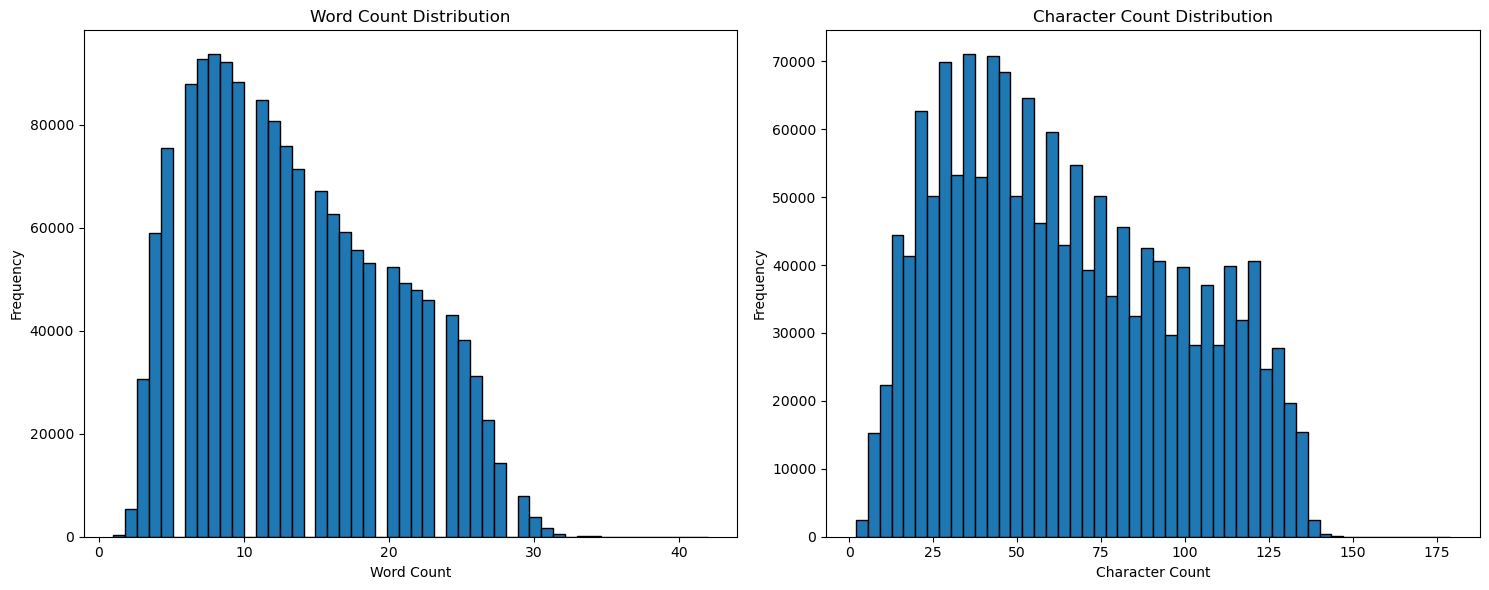

In [29]:
# Selects the word and char count columns
word_char_df = df.select("word_count", "text_length").toPandas()

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Word Count Distribution
axes[0].hist(word_char_df['word_count'], bins=50, edgecolor='black')
axes[0].set_title('Word Count Distribution')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

# Plot Character Count Distribution
axes[1].hist(word_char_df['text_length'], bins=50, edgecolor='black')
axes[1].set_title('Character Count Distribution')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [30]:
# Calculates the correlation between the number of words and characters. 
correlation = df.stat.corr("word_count", "text_length")

print(f"The correlation coefficient between word count and character count is: {correlation}")

2023-11-14 02:11:07,727 WARN memory.MemoryStore: Not enough space to cache rdd_144_7 in memory! (computed 2.3 MiB so far)
2023-11-14 02:11:07,938 WARN memory.MemoryStore: Not enough space to cache rdd_144_8 in memory! (computed 2.4 MiB so far)
2023-11-14 02:11:08,003 WARN memory.MemoryStore: Not enough space to cache rdd_144_9 in memory! (computed 2.4 MiB so far)
2023-11-14 02:11:08,228 WARN memory.MemoryStore: Not enough space to cache rdd_144_10 in memory! (computed 2.4 MiB so far)
2023-11-14 02:11:08,266 WARN memory.MemoryStore: Not enough space to cache rdd_144_11 in memory! (computed 2.4 MiB so far)
2023-11-14 02:11:08,402 WARN memory.MemoryStore: Not enough space to cache rdd_144_12 in memory! (computed 2.4 MiB so far)
2023-11-14 02:11:08,489 WARN memory.MemoryStore: Not enough space to cache rdd_144_13 in memory! (computed 2.4 MiB so far)
2023-11-14 02:11:08,603 WARN memory.MemoryStore: Not enough space to cache rdd_144_14 in memory! (computed 2.3 MiB so far)
2023-11-14 02:11:08

The correlation coefficient between word count and character count is: 0.9652185064975721


The descripte statistics and histograms of the word and character length informs that:

- Word count:
1. The shortest tweet has 1 word and the longest has 42.
2. The average of words per tweet is 13.6 and the StdDev is 6.75. Thus, with a considerable value in the StdDev, the tweets presents variability, but most of them are clusted around the mean value (average). 
3. The distribution plot shows that the majority of tweets are composed by 20 or less words. 
4. There are also longer tweets but they are less frequent, making the word count slightly right-skewed. 

- Character count: 
1. The shortest tweet has 2 char and the longest has 179. (Not surpassing the maximum amount of characters set by twitter at this time, which is 280).
2. The average of character in each tweet is 64, with a standard deviation of 34. Meaning that the based on the avg value the stddev is high (34), presenting a high variation around the average value. 

- Also the correlation between word and char are very high (0.96), and it is not surprising that if the number of words increases, consequently the text length will also increase.

- With some extreme values noticed in the .describe and the histograms, thus the boxplots will be performed to identify outliers, if there is any. 

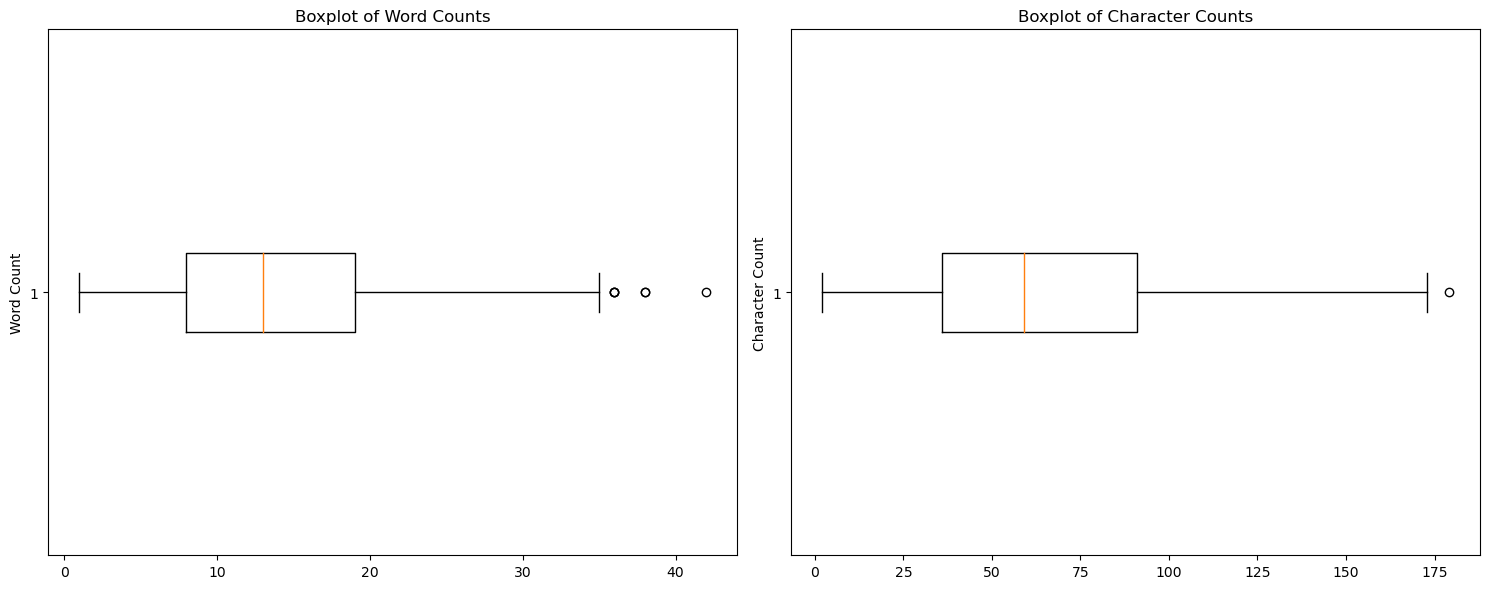

In [31]:
# Creates a figure with two subplots side by side for boxplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Boxplot for Word Count
axes[0].boxplot(word_char_df['word_count'], vert=False)
axes[0].set_title('Boxplot of Word Counts')
axes[0].set_ylabel('Word Count')

# Plot Boxplot for Character Count
axes[1].boxplot(word_char_df['text_length'], vert=False)
axes[1].set_title('Boxplot of Character Counts')
axes[1].set_ylabel('Character Count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

- The boxplots of the number of character and words indicated the presence of outliers. However, users can express their opinions within a max range of characters, turning the outliers for this project a valid data point for analysis.  

- The next step will perform an aggregation to obtain the daily average of tweets word and characters count.

In [32]:
# Extract the daily records and the word count
daily_word_count = df.groupBy("daily_records") \
    .agg(F.avg("word_count").alias("average_word_count"))

# Show the resulting DataFrame
daily_word_count.show()

+-------------+------------------+
|daily_records|average_word_count|
+-------------+------------------+
|   2009-05-13|13.517385943279901|
|   2009-06-25|14.155266236077912|
|   2009-05-01|13.502405408919516|
|   2009-06-15|13.517517654689799|
|   2009-06-07| 13.37701929987189|
|   2009-05-03|13.527716249219061|
|   2009-06-24|14.069212410501194|
|   2009-05-11|13.657252273815223|
|   2009-05-27|13.224611708482676|
|   2009-04-17|13.540637191157348|
|   2009-06-20|13.933439335718386|
|   2009-04-20|13.646291768541158|
|   2009-06-22|14.025946938094444|
|   2009-04-21| 13.78149790013999|
|   2009-05-23|13.680473372781066|
|   2009-05-25|13.911242603550296|
|   2009-06-01|13.590260331330784|
|   2009-04-19| 13.41344820033584|
|   2009-05-18|13.680515838099428|
|   2009-06-21|13.944080357689716|
+-------------+------------------+
only showing top 20 rows



In [33]:
# Creates a df with the daily average for the char count. 
daily_character_count = df.groupBy("daily_records") \
    .agg(F.avg("text_length").alias("average_character_count")) \
    .orderBy("daily_records")

# Show the resulting DataFrame
daily_character_count.show()

2023-11-14 02:12:01,635 WARN memory.MemoryStore: Not enough space to cache rdd_144_101 in memory! (computed 2.4 MiB so far)


+-------------+-----------------------+
|daily_records|average_character_count|
+-------------+-----------------------+
|   2009-04-06|      64.73397243858598|
|   2009-04-07|      65.22715419829635|
|   2009-04-17|      64.03836150845254|
|   2009-04-18|     63.206554807780954|
|   2009-04-19|      63.39782434109659|
|   2009-04-20|      64.69926650366749|
|   2009-04-21|      65.30121325244984|
|   2009-05-01|     63.832531530360164|
|   2009-05-02|      64.19498556339315|
|   2009-05-03|      63.88851025160447|
|   2009-05-04|      64.22819748606972|
|   2009-05-09|      62.71328492097394|
|   2009-05-10|      64.25258208725143|
|   2009-05-11|      64.36141694590714|
|   2009-05-13|      64.40887792848335|
|   2009-05-14|          65.1201171875|
|   2009-05-16|      62.78132543339917|
|   2009-05-17|      63.61345524494741|
|   2009-05-18|      64.95430048394192|
|   2009-05-21|      63.88024516737388|
+-------------+-----------------------+
only showing top 20 rows



- Also looking at the distribution plot where most of the tweets are allocated between word level (5-15) and char level (50-65), the resulted daily averages falls under the expected range. However, a similiar average was not expected. 

2023-11-14 02:12:38,174 WARN memory.MemoryStore: Not enough space to cache rdd_144_50 in memory! (computed 2.4 MiB so far)
2023-11-14 02:12:38,212 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_144_51 in memory.
2023-11-14 02:12:38,221 WARN memory.MemoryStore: Not enough space to cache rdd_144_51 in memory! (computed 384.0 B so far)
2023-11-14 02:12:38,261 WARN memory.MemoryStore: Not enough space to cache rdd_144_52 in memory! (computed 2.4 MiB so far)
2023-11-14 02:12:42,204 WARN memory.MemoryStore: Not enough space to cache rdd_144_104 in memory! (computed 2.4 MiB so far)
2023-11-14 02:12:44,438 WARN memory.MemoryStore: Not enough space to cache rdd_144_143 in memory! (computed 2.4 MiB so far)


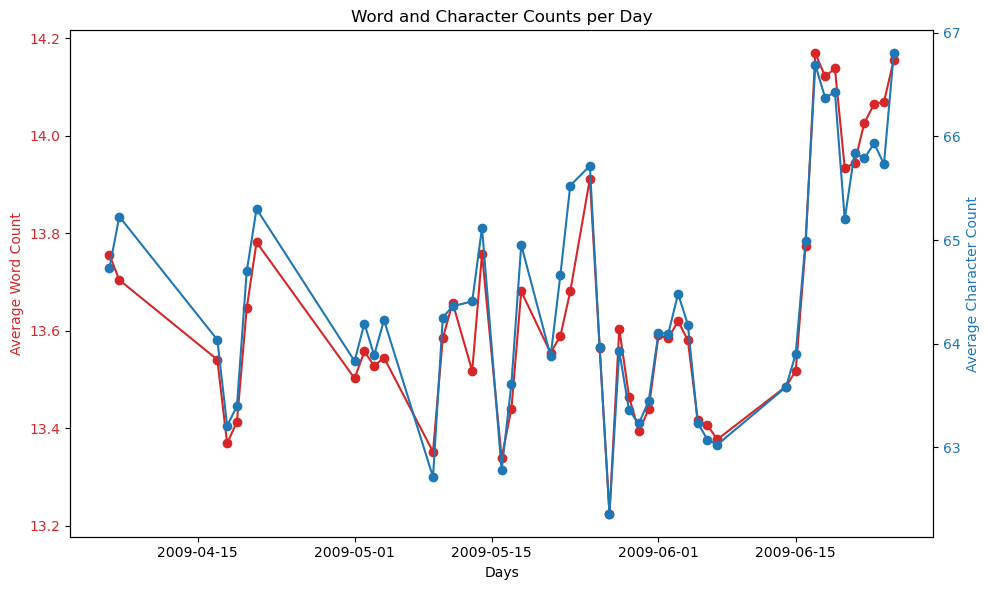

In [34]:
# Convert to Pandas DataFrames
daily_word_count_pd = daily_word_count.toPandas()
daily_character_count_pd = daily_character_count.toPandas()

# Sort Pandas DataFrames by 'daily_records'
daily_word_count_pd = daily_word_count_pd.sort_values('daily_records')
daily_character_count_pd = daily_character_count_pd.sort_values('daily_records')

# Plotting the graph
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Average Word Count', color=color)
ax1.plot(daily_word_count_pd['daily_records'], daily_word_count_pd['average_word_count'], color=color, marker='o', label='Average Word Count')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Character Count', color=color)
ax2.plot(daily_character_count_pd['daily_records'], daily_character_count_pd['average_character_count'], color=color, marker='o', label='Average Character Count')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Word and Character Counts per Day')
plt.tight_layout()
plt.show()

- The line plot with the word and character count per day follow the logical where the number of characters tend to follow the number of words. 
- Only a few days where user posted longer tweets but with less characters.

# EDA Sentiment Label and Scores

In [35]:
# Calculate the total number of tweets
total_count = df.count()

# Group by the 'sentiment' column and count the occurrences
frequency_df = df.groupBy("sentiment_result").count()

# Show the result
frequency_df.show()

2023-11-14 02:12:50,639 WARN memory.MemoryStore: Not enough space to cache rdd_144_6 in memory! (computed 2.4 MiB so far)
2023-11-14 02:12:50,718 WARN memory.MemoryStore: Not enough space to cache rdd_144_7 in memory! (computed 2.3 MiB so far)
2023-11-14 02:12:50,762 WARN memory.MemoryStore: Not enough space to cache rdd_144_8 in memory! (computed 2.4 MiB so far)
2023-11-14 02:12:50,780 WARN memory.MemoryStore: Not enough space to cache rdd_144_9 in memory! (computed 2.4 MiB so far)
2023-11-14 02:12:50,817 WARN memory.MemoryStore: Not enough space to cache rdd_144_11 in memory! (computed 2.4 MiB so far)
2023-11-14 02:12:50,834 WARN memory.MemoryStore: Not enough space to cache rdd_144_10 in memory! (computed 2.4 MiB so far)
2023-11-14 02:12:50,928 WARN memory.MemoryStore: Not enough space to cache rdd_144_12 in memory! (computed 2.4 MiB so far)
2023-11-14 02:12:50,960 WARN memory.MemoryStore: Not enough space to cache rdd_144_13 in memory! (computed 2.4 MiB so far)
2023-11-14 02:12:51,

+----------------+------+
|sentiment_result| count|
+----------------+------+
|             pos|828866|
|             neg|680605|
|         neutral| 85631|
+----------------+------+



- The sentimentDL technique resulted in the majority of positive tweets 800K+, followed by the negatives with 680K+ and Neutral with 85K+. The results are quite imbalanced when comparing the neutrals with other sentiments. 
- The next codes will analyse the statistics and distribution of sentiment scores.

In [36]:
# Sentiment scores descriptive statistics.
df.describe("sentiment_score").show()

2023-11-14 02:13:06,245 WARN memory.MemoryStore: Not enough space to cache rdd_144_5 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:06,595 WARN memory.MemoryStore: Not enough space to cache rdd_144_6 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:06,637 WARN memory.MemoryStore: Not enough space to cache rdd_144_7 in memory! (computed 2.3 MiB so far)
2023-11-14 02:13:06,925 WARN memory.MemoryStore: Not enough space to cache rdd_144_8 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:07,006 WARN memory.MemoryStore: Not enough space to cache rdd_144_9 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:07,122 WARN memory.MemoryStore: Not enough space to cache rdd_144_10 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:07,351 WARN memory.MemoryStore: Not enough space to cache rdd_144_11 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:07,446 WARN memory.MemoryStore: Not enough space to cache rdd_144_12 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:07,5

+-------+-------------------+
|summary|    sentiment_score|
+-------+-------------------+
|  count|            1595102|
|   mean|0.09427761672921196|
| stddev| 0.9290899230327588|
|    min|               -1.0|
|    max|                1.0|
+-------+-------------------+



In [37]:
# Defines bin ranges.
bin_ranges = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Creates a new column for the bins.
# Creates bin conditions using a function.
bin_conditions = when(df.sentiment_score <= bin_ranges[0], str(bin_ranges[0]))
for i in range(1, len(bin_ranges)):
    bin_conditions = bin_conditions.when((df.sentiment_score > bin_ranges[i - 1]) & (df.sentiment_score <= bin_ranges[i]), str(bin_ranges[i]))

# Adds a default case if needed.
bin_conditions = bin_conditions.otherwise(str(bin_ranges[-1]))

# Apply the binning.
df_with_bins = df.select("sentiment_score").withColumn("score_bin", bin_conditions)

# Group by the bins and the count.
histogram_data = df_with_bins.groupBy("score_bin").count().collect()

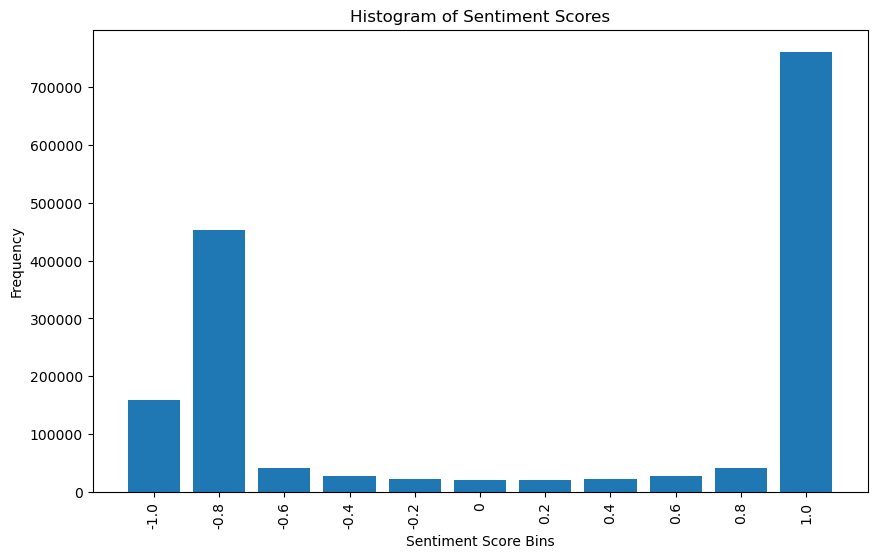

In [38]:
# Convert the score_bin from a range string to the lower bound for sorting
histogram_data_sorted = sorted(histogram_data, key=lambda x: float(x['score_bin'].split(' to ')[0]))

# Now extract the bins and counts again, which should be sorted
bins_sorted = [row['score_bin'] for row in histogram_data_sorted]
counts_sorted = [row['count'] for row in histogram_data_sorted]

# Plot the histogram with the sorted bins
plt.figure(figsize=(10, 6))
plt.bar(range(len(counts_sorted)), counts_sorted, align='center')  # Use numerical x-axis
plt.xticks(range(len(bins_sorted)), bins_sorted, rotation=90)  # Add bin labels as x-tick labels
plt.xlabel('Sentiment Score Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores')
plt.show()


The previous codes shows that:
- The range of the scores are between -1 and 1 (as expected from the model).
- The sentiment scores have the average of 0.09, informing that the overall sentiment of the dataframe is slightly positive. 
- The StdDev of 0.929 shows that the scores will present a high variability and based on the range it will vary between the extreme points. 
- Due to its characteristics the distribution do not present any skewness, but rather a big difference between extreme "opinions" and neutral tweets. 
- By investigating the histogram where it shows that most of the values are located at the extremes (Bimodal distribution) and because of the mathematical operation the average will tend to the center.
<br><br><br>

Further analysis will be perform on the daily basis, thus the next step will aggregate to generate the overall sentment of the day. However, the distribution of tweets are unequal among the recorded days. Therefore, different techniques will be attemped to chose the most appropriate to continue.  

In [39]:
# Calculate the median sentiment score for each day
daily_median_sentiment = df.groupBy('daily_records').agg(F.expr('percentile_approx(sentiment_score, 0.5)').alias('median_sentiment'))
daily_median_sentiment.show()

2023-11-14 02:13:37,290 WARN memory.MemoryStore: Not enough space to cache rdd_144_7 in memory! (computed 2.3 MiB so far)
2023-11-14 02:13:37,631 WARN memory.MemoryStore: Not enough space to cache rdd_144_8 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:37,696 WARN memory.MemoryStore: Not enough space to cache rdd_144_9 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:38,045 WARN memory.MemoryStore: Not enough space to cache rdd_144_10 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:38,060 WARN memory.MemoryStore: Not enough space to cache rdd_144_11 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:38,496 WARN memory.MemoryStore: Not enough space to cache rdd_144_12 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:38,504 WARN memory.MemoryStore: Not enough space to cache rdd_144_13 in memory! (computed 2.4 MiB so far)
2023-11-14 02:13:38,821 WARN memory.MemoryStore: Not enough space to cache rdd_144_14 in memory! (computed 2.3 MiB so far)
2023-11-14 02:13:38

+-------------+----------------+
|daily_records|median_sentiment|
+-------------+----------------+
|   2009-05-13|           0.725|
|   2009-06-25|          -0.711|
|   2009-05-01|           0.757|
|   2009-06-15|           0.716|
|   2009-06-07|           0.826|
|   2009-05-03|           0.753|
|   2009-06-24|          -0.591|
|   2009-05-11|           0.606|
|   2009-05-27|           0.501|
|   2009-04-17|            0.83|
|   2009-06-20|           -0.59|
|   2009-04-20|            0.74|
|   2009-06-22|           -0.56|
|   2009-04-21|            0.75|
|   2009-05-23|           0.785|
|   2009-05-25|           0.956|
|   2009-06-01|           0.733|
|   2009-04-19|           0.799|
|   2009-05-18|           0.766|
|   2009-06-21|          -0.522|
+-------------+----------------+
only showing top 20 rows



In [40]:
# For weighted average, calculate the mean sentiment and count of tweets for each day
daily_sentiment = df.select("sequence", "sentiment_score", "daily_records").groupBy('daily_records').agg(
    F.avg('sentiment_score').alias('average_sentiment'),
    F.count('sequence').alias('tweet_count')
)

# Add a normalized weight for each day based on tweet count
max_tweets = daily_sentiment.agg(F.max('tweet_count')).first()[0]
daily_sentiment = daily_sentiment.withColumn('weight', F.col('tweet_count') / max_tweets)

# Calculate the weighted average sentiment
weighted_average_sentiment = daily_sentiment.withColumn('weighted_sentiment', F.col('weight') * F.col('average_sentiment'))

weighted_average_sentiment.show()

2023-11-14 02:14:14,388 WARN memory.MemoryStore: Not enough space to cache rdd_144_70 in memory! (computed 2.3 MiB so far)
2023-11-14 02:14:17,431 WARN memory.MemoryStore: Not enough space to cache rdd_144_112 in memory! (computed 2.4 MiB so far)
2023-11-14 02:14:17,515 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_144_114 in memory.
2023-11-14 02:14:17,524 WARN memory.MemoryStore: Not enough space to cache rdd_144_114 in memory! (computed 384.0 B so far)
2023-11-14 02:14:18,932 WARN memory.MemoryStore: Not enough space to cache rdd_144_139 in memory! (computed 2.4 MiB so far)
2023-11-14 02:14:19,013 WARN memory.MemoryStore: Not enough space to cache rdd_144_141 in memory! (computed 2.4 MiB so far)
2023-11-14 02:14:19,083 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_144_142 in memory.
2023-11-14 02:14:19,090 WARN memory.MemoryStore: Not enough space to cache rdd_144_

+-------------+--------------------+-----------+--------------------+--------------------+
|daily_records|   average_sentiment|tweet_count|              weight|  weighted_sentiment|
+-------------+--------------------+-----------+--------------------+--------------------+
|   2009-05-13|  0.1114194821208385|       4055| 0.03645337025117316|0.004061615634944894|
|   2009-06-25|-0.11984127549204088|      19663|  0.1767651342167245|-0.02118375914705406|
|   2009-05-01| 0.12678325315303599|       7691| 0.06914004207195383|0.008765799457020081|
|   2009-06-15| 0.11288101698321772|     109461|  0.9840252431722972| 0.11107777018644703|
|   2009-06-07| 0.14292165481038632|      96011|  0.8631133245833258| 0.12335758463834301|
|   2009-05-03| 0.12356423581530081|      35214| 0.31656448336000287|0.039116048472644264|
|   2009-06-24|-0.09201750198886233|       6285| 0.05650047645588738|-0.00519903270465...|
|   2009-05-11| 0.09498827190043081|       4178| 0.03755910749923587|0.003567674715474...|

In [41]:
# Collect the data to the local environment
daily_median_sentiment_data = daily_median_sentiment.sort('daily_records').collect()

# Extract dates and median sentiments for plotting
dates = [row['daily_records'] for row in daily_median_sentiment_data]
median_sentiments = [row['median_sentiment'] for row in daily_median_sentiment_data]

# Collect the data to the local environment
weighted_average_sentiment_data = weighted_average_sentiment.sort('daily_records').collect()

# Extract dates and weights and averages.
dates = [row['daily_records'] for row in weighted_average_sentiment_data]
weighted_avg_sentiments = [row['weighted_sentiment'] for row in weighted_average_sentiment_data]
avg_sentiments = [row['average_sentiment'] for row in weighted_average_sentiment_data]

2023-11-14 02:14:46,666 WARN memory.MemoryStore: Not enough space to cache rdd_144_7 in memory! (computed 2.3 MiB so far)
2023-11-14 02:14:46,889 WARN memory.MemoryStore: Not enough space to cache rdd_144_8 in memory! (computed 2.4 MiB so far)
2023-11-14 02:14:46,919 WARN memory.MemoryStore: Not enough space to cache rdd_144_9 in memory! (computed 2.4 MiB so far)
2023-11-14 02:14:47,093 WARN memory.MemoryStore: Not enough space to cache rdd_144_10 in memory! (computed 2.4 MiB so far)
2023-11-14 02:14:47,115 WARN memory.MemoryStore: Not enough space to cache rdd_144_11 in memory! (computed 2.4 MiB so far)
2023-11-14 02:14:47,274 WARN memory.MemoryStore: Not enough space to cache rdd_144_12 in memory! (computed 2.4 MiB so far)
2023-11-14 02:14:47,346 WARN memory.MemoryStore: Not enough space to cache rdd_144_13 in memory! (computed 2.4 MiB so far)
2023-11-14 02:14:47,514 WARN memory.MemoryStore: Not enough space to cache rdd_144_14 in memory! (computed 2.3 MiB so far)
2023-11-14 02:14:47

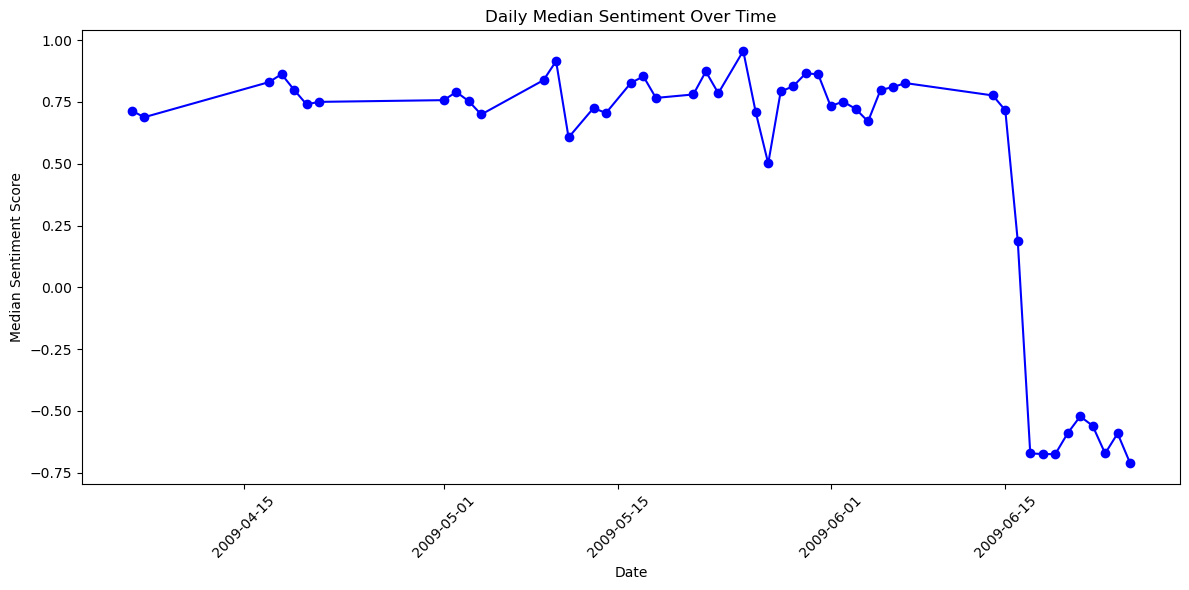

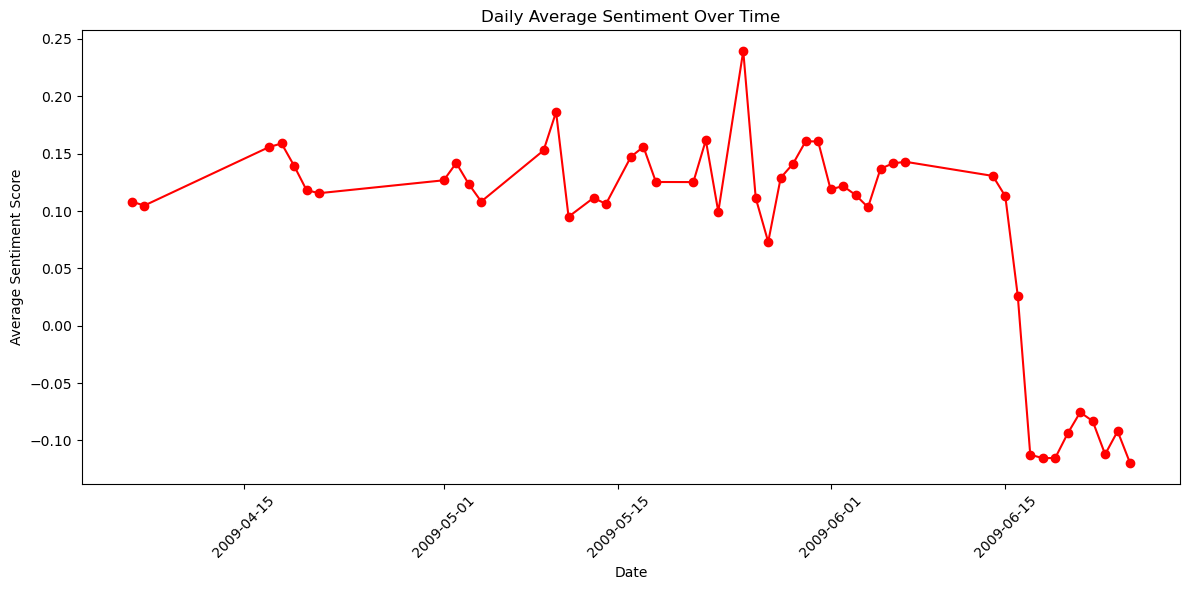

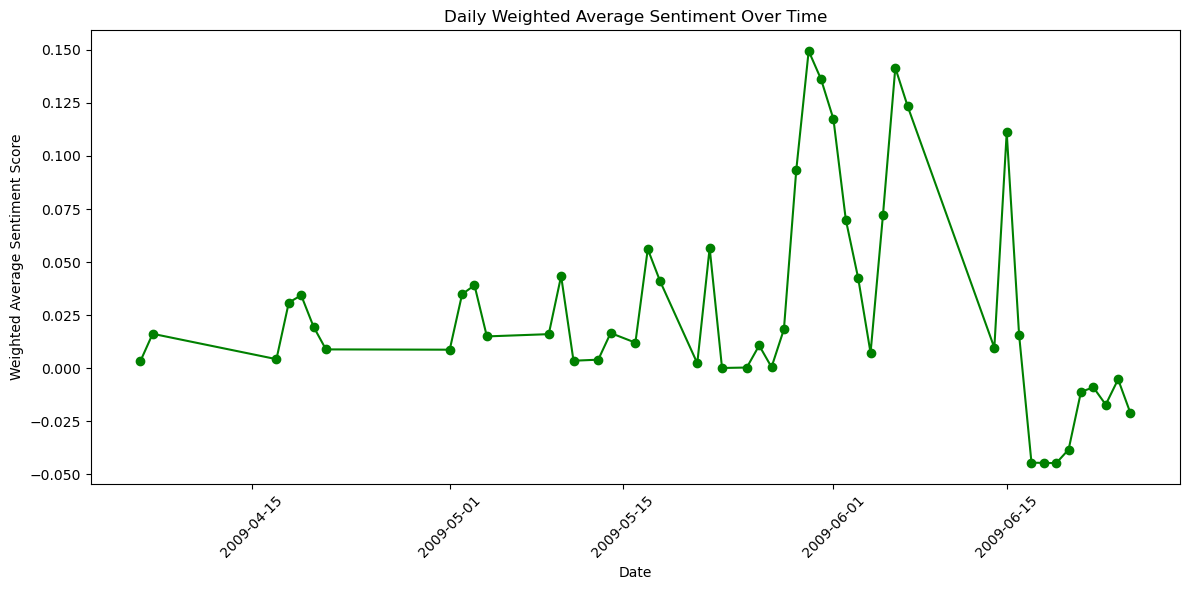

In [42]:
# Now plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, median_sentiments, marker='o', linestyle='-', color='blue')
plt.title('Daily Median Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Median Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Now plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, avg_sentiments, marker='o', linestyle='-', color='red')
plt.title('Daily Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Now plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, weighted_avg_sentiments, marker='o', linestyle='-', color='green')
plt.title('Daily Weighted Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Weighted Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

Three techniques applied to obtain the overall sentiment of the day resulted in the following insights.
- By using average or median it yielded a similar pattern, although having different representation scales. 
- By using weighted average it presented a different format, taking in to account the weights based on the volume of tweets posted per day.

The chosen approach to aggregate the daily sentiment score will be performed using the weighted average: 
- More data available on these days, presenting not only more samples, but with different scale of moods and polarities. 
- Days with few tweets (hundreds), can have numerous extreme scores which can lead to skewness. But days with more tweets (+200K) may represent a day  that something important was happening that day.

The chosen approach has a direct affect on the shape, which will be strongly correlated to the volume of tweets as observed in the following plot.

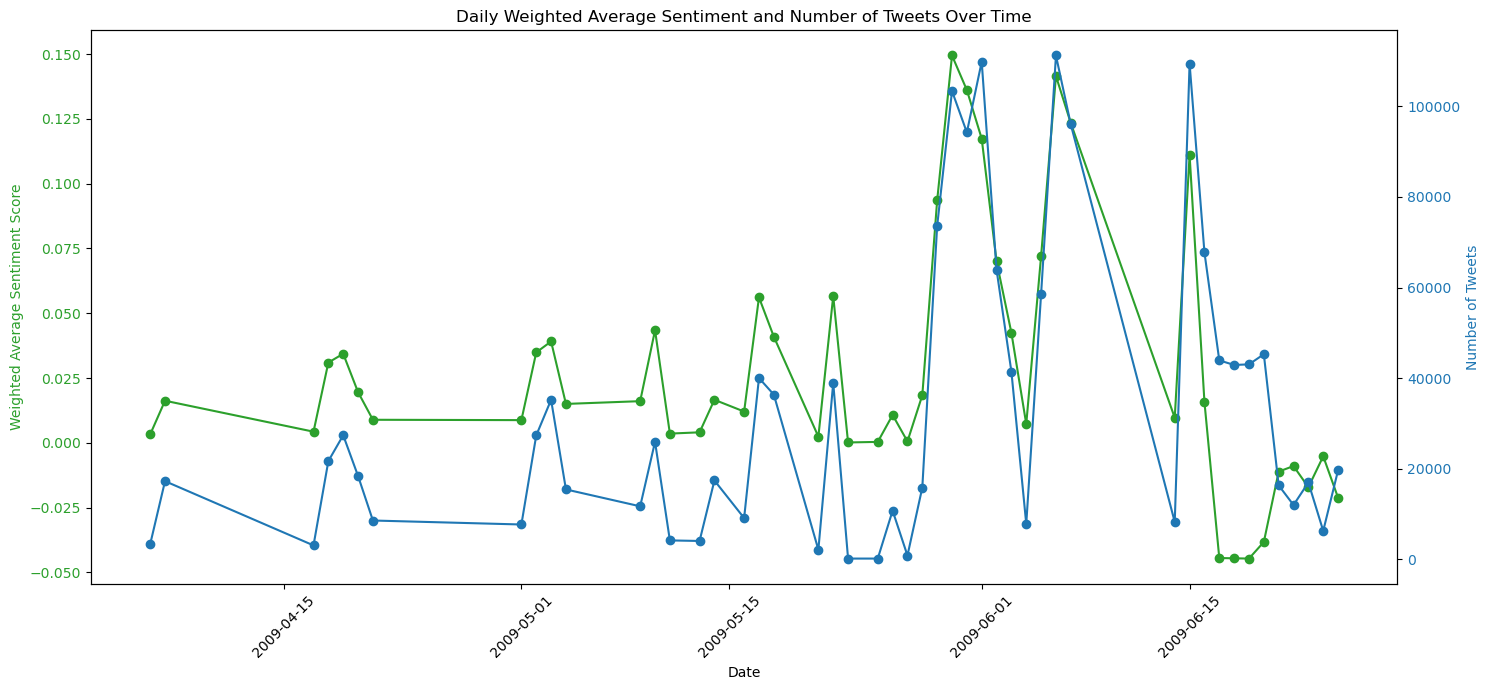

In [43]:
# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot the weighted average sentiment over time on the primary y-axis
color = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Average Sentiment Score', color=color)
ax1.plot(dates, weighted_avg_sentiments, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Instantiate a second y-axis, sharing the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Number of Tweets', color=color)  
ax2.plot(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Daily Weighted Average Sentiment and Number of Tweets Over Time')
fig.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

plt.show()

- As mentioned earlier, but also by the characteristics of the technique, most of the sentiment scores tend to follow the volume of the tweets. 

The dataframe to be used in the time seties analysis contains the date of the record (daily_records), the weight (based on volume of tweets) and the the weighted sentiment score. 

### Time-Series Analysis using daily overall sentiment score. 

The analysis will be carried out using the days as the time points and the weighted sentiment. 

In [44]:
# Drops the columns that are no longer needed for the next stages.
df_daily_sent = weighted_average_sentiment.drop("average_sentiment", "tweet_count")

# Reducing the precision to 3 and 5 decimals can keep the precision and at the same making the column 
# more memory friendly.
df_daily_sent = df_daily_sent.withColumn("weighted_sentiment", round(df_daily_sent["weighted_sentiment"], 3))
df_daily_sent = df_daily_sent.withColumn("weight", round(df_daily_sent["weight"], 5))
df_daily_sent.show()

+-------------+-------+------------------+
|daily_records| weight|weighted_sentiment|
+-------------+-------+------------------+
|   2009-05-13|0.03645|             0.004|
|   2009-06-25|0.17677|            -0.021|
|   2009-05-01|0.06914|             0.009|
|   2009-06-15|0.98403|             0.111|
|   2009-06-07|0.86311|             0.123|
|   2009-05-03|0.31656|             0.039|
|   2009-06-24| 0.0565|            -0.005|
|   2009-05-11|0.03756|             0.004|
|   2009-05-27|0.00752|             0.001|
|   2009-04-17|0.02765|             0.004|
|   2009-06-20|0.40707|            -0.038|
|   2009-04-20|0.16546|              0.02|
|   2009-06-22|0.10775|            -0.009|
|   2009-04-21|0.07706|             0.009|
|   2009-05-23|0.00152|               0.0|
|   2009-05-25|0.00152|               0.0|
|   2009-06-01|0.98761|             0.117|
|   2009-04-19|0.24626|             0.034|
|   2009-05-18|0.32694|             0.041|
|   2009-06-21|0.14678|            -0.011|
+----------

In [45]:
# Calculate the minimum and maximum dates using fully qualified function names
min_max_dates = df_daily_sent.agg(F.min("daily_records").alias("start_date"), 
                       F.max("daily_records").alias("end_date")).collect()
start_date, end_date = min_max_dates[0]['start_date'], min_max_dates[0]['end_date']

# Print the start and end dates
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

2023-11-14 02:16:14,988 WARN memory.MemoryStore: Not enough space to cache rdd_144_7 in memory! (computed 2.3 MiB so far)
2023-11-14 02:16:15,006 WARN memory.MemoryStore: Not enough space to cache rdd_144_8 in memory! (computed 2.4 MiB so far)
2023-11-14 02:16:15,089 WARN memory.MemoryStore: Not enough space to cache rdd_144_9 in memory! (computed 2.4 MiB so far)
2023-11-14 02:16:15,114 WARN memory.MemoryStore: Not enough space to cache rdd_144_10 in memory! (computed 2.4 MiB so far)
2023-11-14 02:16:15,159 WARN memory.MemoryStore: Not enough space to cache rdd_144_11 in memory! (computed 2.4 MiB so far)
2023-11-14 02:16:15,183 WARN memory.MemoryStore: Not enough space to cache rdd_144_12 in memory! (computed 2.4 MiB so far)
2023-11-14 02:16:15,221 WARN memory.MemoryStore: Not enough space to cache rdd_144_13 in memory! (computed 2.4 MiB so far)
2023-11-14 02:16:15,345 WARN memory.MemoryStore: Not enough space to cache rdd_144_14 in memory! (computed 2.3 MiB so far)
2023-11-14 02:16:15

Start Date: 2009-04-06
End Date: 2009-06-25


- The data ranges from 06-04-2009 to 25-06-2009

With gaps identified in early stages, the following codes will add the missing days so the imputation of sentiment scores can be performed. 

In [46]:
from pyspark.sql.functions import explode, sequence, to_date, lit

# Create a DataFrame with a range of dates
date_df = spark.sql("SELECT explode(sequence(to_date('2009-04-06'), to_date('2009-06-25'), interval 1 day)) as daily_records")
date_df.show()

+-------------+
|daily_records|
+-------------+
|   2009-04-06|
|   2009-04-07|
|   2009-04-08|
|   2009-04-09|
|   2009-04-10|
|   2009-04-11|
|   2009-04-12|
|   2009-04-13|
|   2009-04-14|
|   2009-04-15|
|   2009-04-16|
|   2009-04-17|
|   2009-04-18|
|   2009-04-19|
|   2009-04-20|
|   2009-04-21|
|   2009-04-22|
|   2009-04-23|
|   2009-04-24|
|   2009-04-25|
+-------------+
only showing top 20 rows



In [47]:
# Join with the existing DataFrame
result_df = date_df.join(df_daily_sent, "daily_records", "left_outer")

# Show the result
result_df.show()

+-------------+-------+------------------+
|daily_records| weight|weighted_sentiment|
+-------------+-------+------------------+
|   2009-04-11|   null|              null|
|   2009-04-17|0.02765|             0.004|
|   2009-04-20|0.16546|              0.02|
|   2009-04-15|   null|              null|
|   2009-04-16|   null|              null|
|   2009-04-13|   null|              null|
|   2009-04-21|0.07706|             0.009|
|   2009-04-19|0.24626|             0.034|
|   2009-04-25|   null|              null|
|   2009-04-14|   null|              null|
|   2009-04-26|   null|              null|
|   2009-04-07|0.15514|             0.016|
|   2009-04-08|   null|              null|
|   2009-04-18|0.19502|             0.031|
|   2009-04-22|   null|              null|
|   2009-04-24|   null|              null|
|   2009-04-06|0.03001|             0.003|
|   2009-04-12|   null|              null|
|   2009-04-23|   null|              null|
|   2009-04-09|   null|              null|
+----------

In [48]:
# Find the count of missing values in the 'text' column
missing_values_count = result_df.filter(result_df.weighted_sentiment.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

Number of missing values in 'text' column: 33


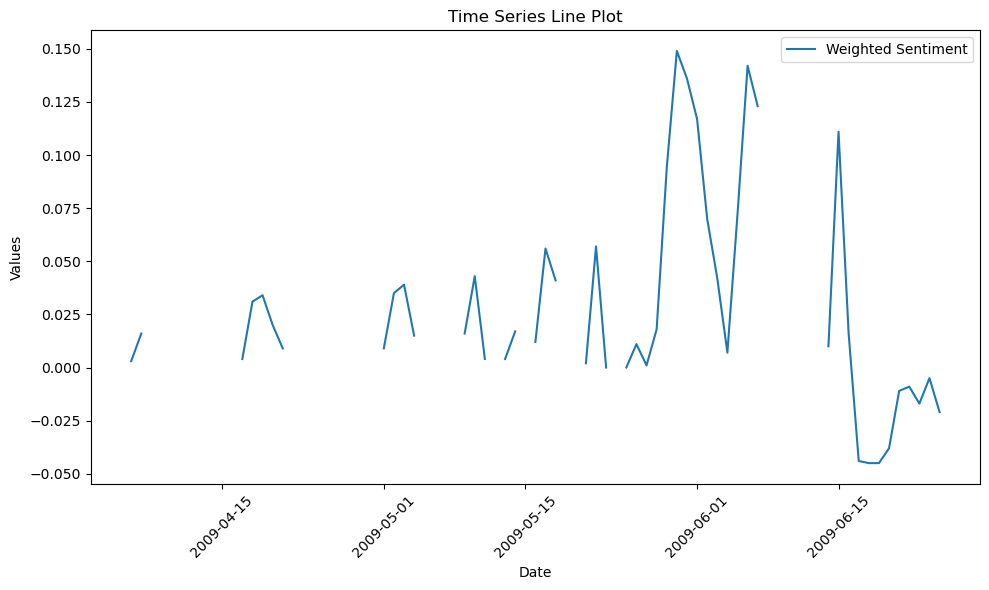

In [49]:
# Order the DataFrame by date
result_df = result_df.orderBy("daily_records")

# Convert to Pandas DataFrame for plotting
pandas_df = result_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['daily_records'], pandas_df['weighted_sentiment'], label='Weighted Sentiment')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Line Plot')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The previous code displayed the line plot showing the gaps in the dataframe:
- There are more missing data at the start of the period. 
- The plot is important to have as a reference to check the perfomance of the techniques applied. 

- The dataframe became much smaller compared to the original set 1.6 million to 81 observations, thus Pandas format will be used also for visualization purpose.

In [50]:
# Reset the index to the date column
pandas_df.reset_index(inplace=True)

# Creating a copy to use as reference.
df_og = result_df.toPandas()

### Imputation techniques attempted

- To perform time series analysis all the data points in the range has to be filled with score sentiment.
- To fill all the missing days, different approaches will be applied and evaluated through its statistical characteristics. 
- In total 4 techniques will be tested Linear Interpolation, Cubic Interpolation, Exponential Moving Average (EMA) and Rolling Weighted Average (Volume of tweets). 
- The coding to apply the imputation will be called and the analysis will be carried out comparing the four techniques at the same time.


#### Linear Interpolation. 

In [51]:
# Applying cubic interpolation
pandas_df['weighted_sentiment_linear_interp'] = pandas_df['weighted_sentiment'].interpolate(method='linear')

#### Exponential Moving Average (EMA).

1. A technique that uses the value of alpha to help smooth short term functuations, which the can be observed in the scores overtime. 
2. To avoid numerous figures and cells with the same code, only one EMA code is going to be displayed.

- Alpha values tested: ranges from 0.1 to 1, however all the figures resulted in the same characteristics as observerd in the next figure.

In [52]:
# Creating a copy to use for EMA
pandas_df2 = result_df.toPandas()

def ema_imputation(series, alpha):
    imputed_series = series.copy()
    missing_indices = series.isnull()

    for i in range(len(series)):
        if i == 0:
            if missing_indices[i]:
                # Handle first element if it's missing
                imputed_series[i] = 0  # or some other default value
        else:
            if missing_indices[i]:
                # Use EMA formula to impute missing values
                imputed_series[i] = (1 - alpha) * imputed_series[i - 1]
            else:
                # If not missing, keep the original value
                imputed_series[i] = series[i]

    return imputed_series

In [53]:
# Choose the alpha value (smoothing factor)
alpha = 0.5 

# Apply EMA imputation to the 'weighted_sentiment' column
pandas_df2['imputed_weighted_sentiment'] = ema_imputation(pandas_df2['weighted_sentiment'], alpha)

#### Rolling Weighted Average

- The weights that are going to be used are from the volume of tweets, the same value used to aggregate the tweets to daily averages.
- To apply the rolling weighted average the weights have to be filled, thus the median approach will be selected to perform this.
- The mean The mean provided a higher value (aprox 0.29), thus not giving too much weight to the imputed values (next stage).
- There are many consecutive days with missing scores, thus the window size of 10 is the minimum value to fill all the gaps.

In [54]:
# Creating a copy to use for Rolling Weighted Average.
pandas_df3 = result_df.toPandas() 

In [55]:
# Calculate the median of the weights
median_weight = pandas_df3['weight'].median()

# Impute missing weights with the median
pandas_df3['weight'] = pandas_df3['weight'].fillna(median_weight)

In [56]:
# Define the rolling window size
window_size = 10  # set to 10 to fill all the missing days. 

# Compute the weighted sum and the sum of weights for the rolling window
rolling_weighted_sum = pandas_df3['weighted_sentiment'].mul(pandas_df3['weight']).rolling(window=window_size, min_periods=1).sum()
rolling_weight_sum = pandas_df3['weight'].rolling(window=window_size, min_periods=1).sum()

# Calculate the rolling weighted average
rolling_weighted_avg = rolling_weighted_sum / rolling_weight_sum

# Replace NaN values in 'weighted_sentiment' with the rolling weighted average
pandas_df3['imputed_weighted_sentiment'] = pandas_df3['weighted_sentiment'].fillna(rolling_weighted_avg)

pandas_df3.head(20)


,daily_records,weight,weighted_sentiment,imputed_weighted_sentiment
0,2009-04-06,0.030010,0.003,0.003000
1,2009-04-07,0.155140,0.016,0.016000
2,2009-04-08,0.171115,NaN,0.007220
3,2009-04-09,0.171115,NaN,0.004877
4,2009-04-10,0.171115,NaN,0.003683
5,2009-04-11,0.171115,NaN,0.002958
6,2009-04-12,0.171115,NaN,0.002472
7,2009-04-13,0.171115,NaN,0.002123
8,2009-04-14,0.171115,NaN,0.001860
9,2009-04-15,0.171115,NaN,0.001655


#### Cubic Imputation

In [57]:
# Creating a copy to use for Cubic Imputation.
pandas_df1 = result_df.toPandas() 

In [58]:
# Applying cubic interpolation
pandas_df1['weighted_sentiment_cubic_interp'] = pandas_df1['weighted_sentiment'].interpolate(method='cubic')

#### Analysis of Imputations 

With all four approaches applied, the analysis will be performed in the following cells including: 

<b>1. Lineplots</b>: sentiment scores overtime to visualize the impact of the imputed scores overtime.
- Two timeseries data are plotted on top of each other and to facilitate the distinction of the imputed values in the line, the scores will have different colors and different marks for the time point. 

<b>2. Histograms</b>: including the kde curve.

<b>3. Descriptive Statistics.</b>

<b>4. Boxplots: Distribution and Outiliers.</b>

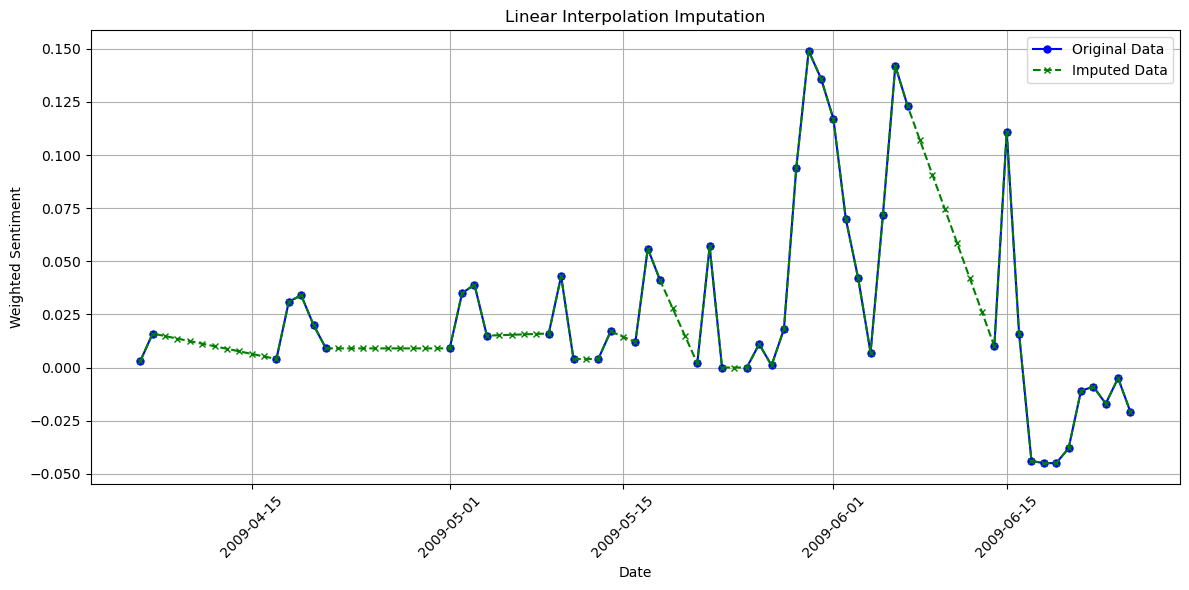

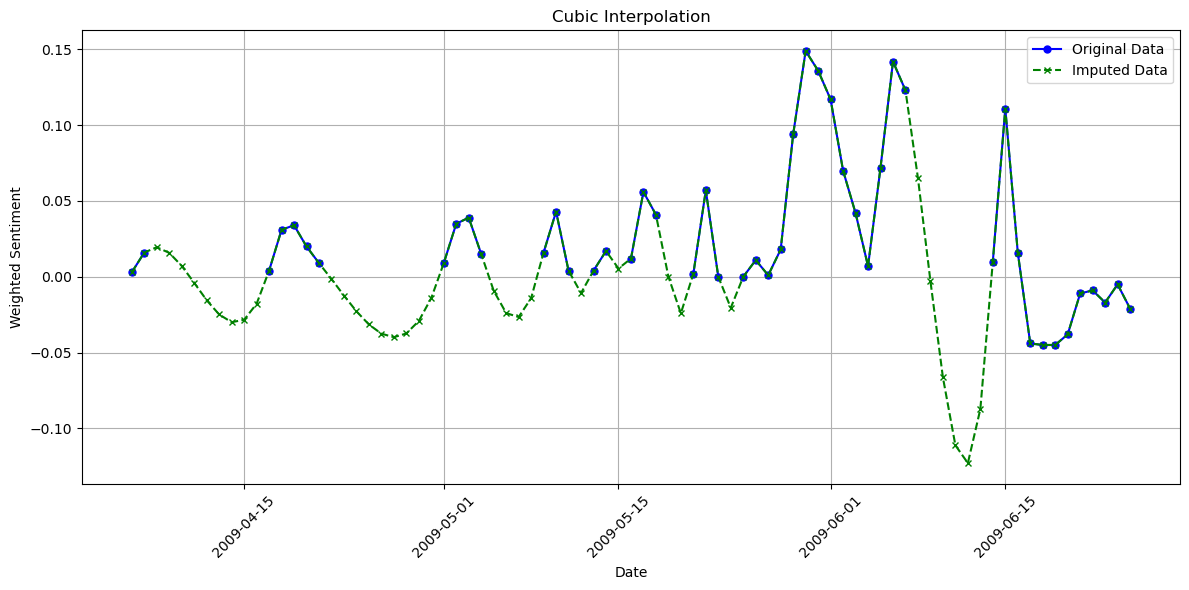

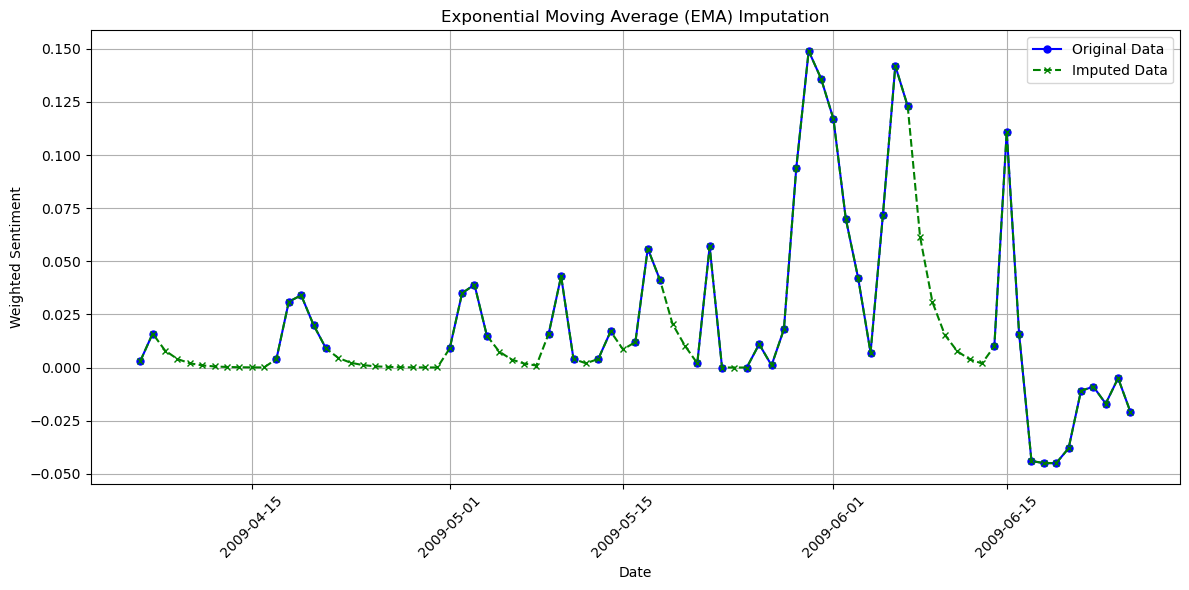

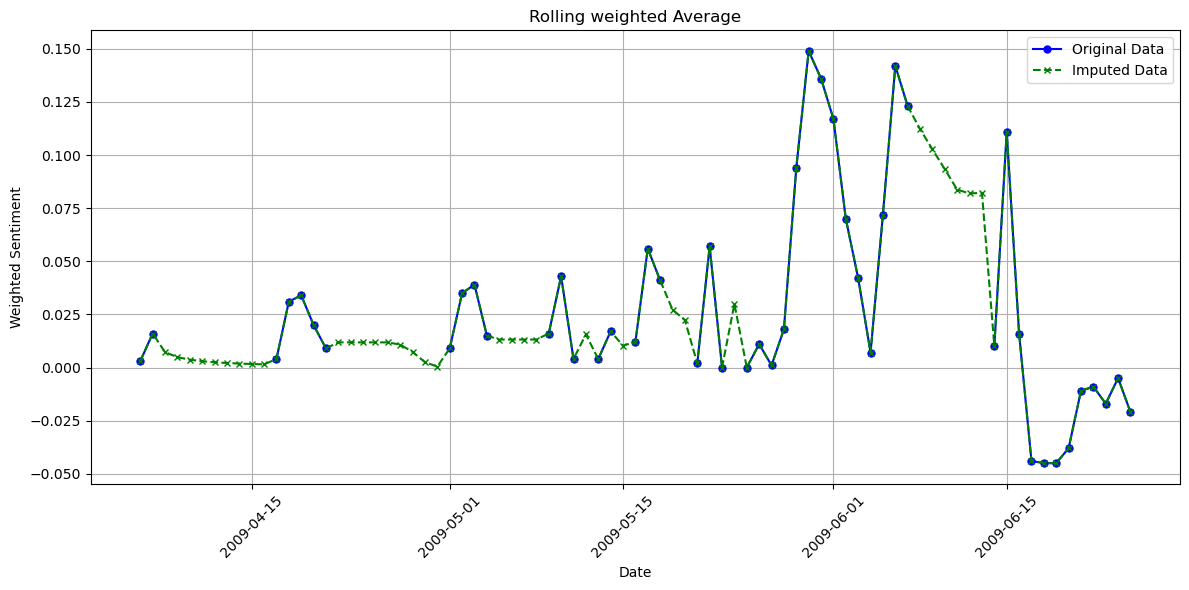

In [59]:
# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df['daily_records'], pandas_df['weighted_sentiment_linear_interp'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Linear Interpolation Imputation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df1['daily_records'], pandas_df1['weighted_sentiment_cubic_interp'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Cubic Interpolation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df2['daily_records'], pandas_df2['imputed_weighted_sentiment'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Exponential Moving Average (EMA) Imputation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df3['daily_records'], pandas_df3['imputed_weighted_sentiment'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Rolling weighted Average')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Lineplots Analysis

- Linear: It presented the expected results adding scores in a linear way from on sentiment score to the other. The approach did not added any huge spikes or variation to the data.

- Cubic: The method added more variability to the dataframe, especially with a huge spike (negative) at the last quarter (the original lowets value was around -0.05 and after the approach was -0.1).

- EMA: The results are similar provided by the linear method, despite trying different alpha values (range between 0.1 and 1) the values and the shape barely suffered any change.

- Rolling Weighted Average: The approach presented scores that it does not add much variability to the scores and do not introduce huge spikes. However, it added more "seasonality" to the data with more ups and downs in comparison to the last techniques.  

In [100]:
# Applies .describe() to each DataFrame
description_df = df_og['weighted_sentiment'].describe()
description_df1 = pandas_df['weighted_sentiment_linear_interp'].describe()
description_df2 = pandas_df1['weighted_sentiment_cubic_interp'].describe()
description_df3 = pandas_df2['imputed_weighted_sentiment'].describe()
description_df4 = pandas_df3['imputed_weighted_sentiment'].describe()

# Prints for further analysis.
print("Description of sentiment score without imputation:\n", description_df)
print("Description of sentiment score with linear imputation:\n", description_df1)
print("\nDescription of sentiment score with cubic imputation:\n", description_df2)
print("\nDescription of sentiment score with EMA imputation:\n", description_df3)
print("\nDescription of sentiment score with rolling weighted avg imputation:\n", description_df4)


Description of sentiment score without imputation:
 count    48.000000
mean      0.028146
std       0.048481
min      -0.045000
25%       0.001750
50%       0.015500
75%       0.042250
max       0.149000
Name: weighted_sentiment, dtype: float64
Description of sentiment score with linear imputation:
 count    81.000000
mean      0.025241
std       0.040604
min      -0.045000
25%       0.006400
50%       0.012400
75%       0.035000
max       0.149000
Name: weighted_sentiment_linear_interp, dtype: float64

Description of sentiment score with cubic imputation:
 count    81.000000
mean      0.007376
std       0.050154
min      -0.122943
25%      -0.021000
50%       0.002000
75%       0.019489
max       0.149000
Name: weighted_sentiment_cubic_interp, dtype: float64

Description of sentiment score with EMA imputation:
 count    81.000000
mean      0.019165
std       0.039461
min      -0.045000
25%       0.000281
50%       0.004500
75%       0.020500
max       0.149000
Name: imputed_weighted_s

#### Descriptive Statistics.

The statistical properties before and after de imputation shows that the Cubic approach caused the bigger change in its properties, increasing the standard deviation but also imputing negative values that reduced the minimum value of the sentiment score. In contrast, the rolling weighted AVG was the one that kept the properties closest to the original. 

Text(0.5, 1.0, 'Distribution in Linear')

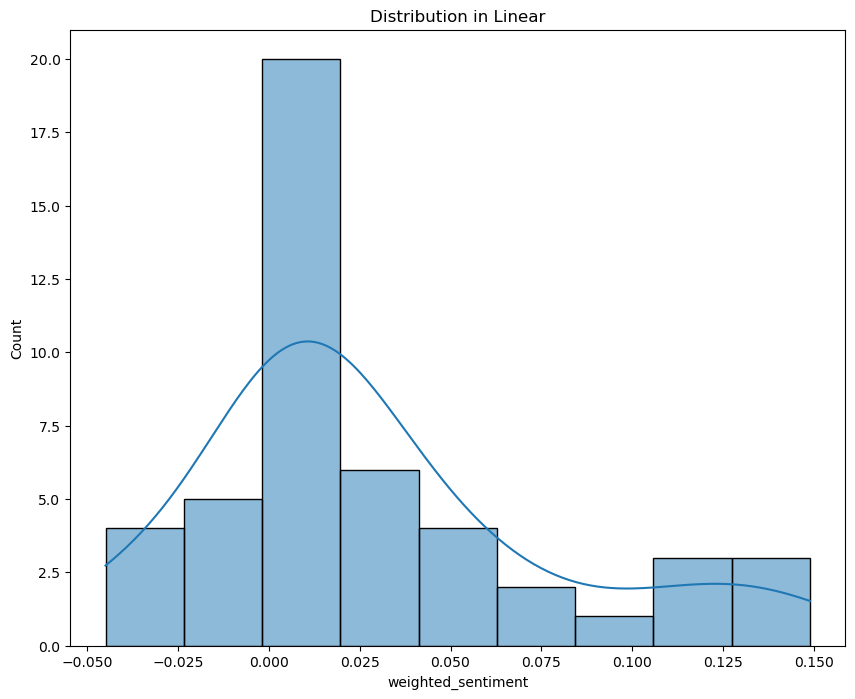

In [102]:
plt.figure(figsize=(10, 8))  # Set the size of the overall figure

# Plot Distribution without imputations.
sns.histplot(df_og['weighted_sentiment'], kde=True)
plt.title('Distribution Without Imputation')

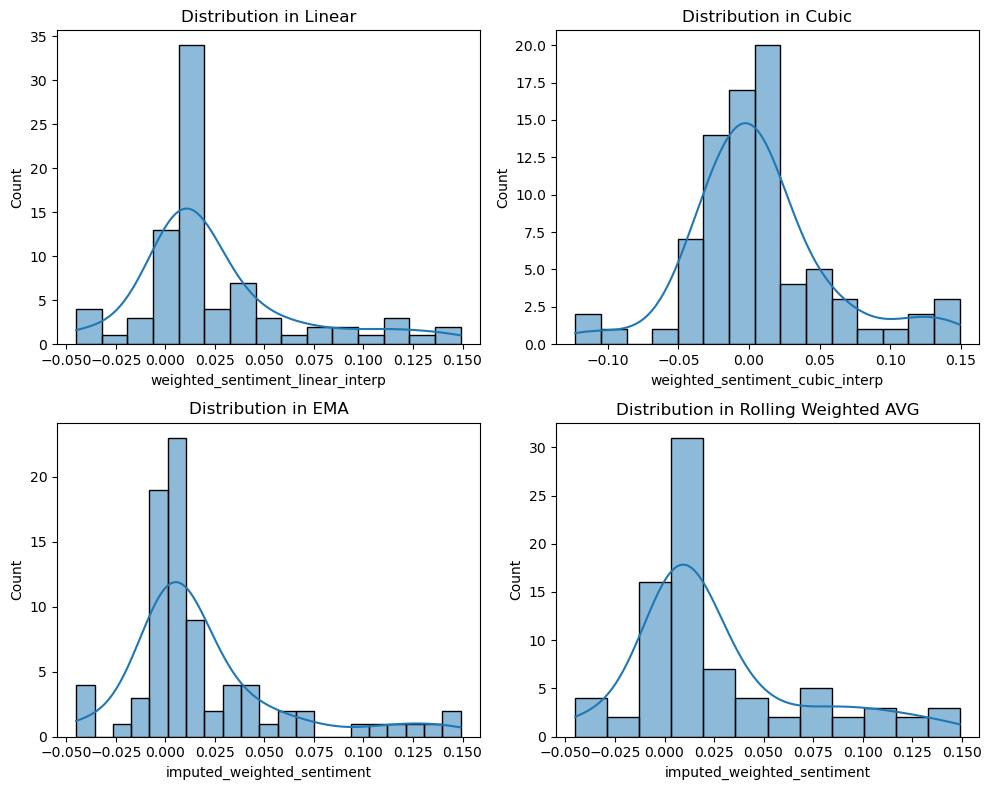

In [61]:
plt.figure(figsize=(10, 8))  # Set the size of the overall figure

# Plot for DataFrame 1
plt.subplot(2, 2, 1)  # Row 1, Column 1
sns.histplot(pandas_df['weighted_sentiment_linear_interp'], kde=True)
plt.title('Distribution in Linear')

# Plot for DataFrame 2
plt.subplot(2, 2, 2)  # Row 1, Column 2
sns.histplot(pandas_df1['weighted_sentiment_cubic_interp'], kde=True)
plt.title('Distribution in Cubic')

# Plot for DataFrame 3
plt.subplot(2, 2, 3)  # Row 2, Column 1
sns.histplot(pandas_df2['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution in EMA')

# Plot for DataFrame 4
plt.subplot(2, 2, 4)  # Row 2, Column 2
sns.histplot(pandas_df3['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution in Rolling Weighted AVG')

plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Display the plots


#### Distribution Before and After Imputation

The distribution plots shows that techniches like the linear, EMA and rolling average maintain the shape close to the original which is slightly right-skewed. However, because the cubic imputation added not only more negative values but with a large scale it made the scores more normally distributed in comparison with the original. 

Text(0.5, 1.0, 'Boxplot Without Imputation')

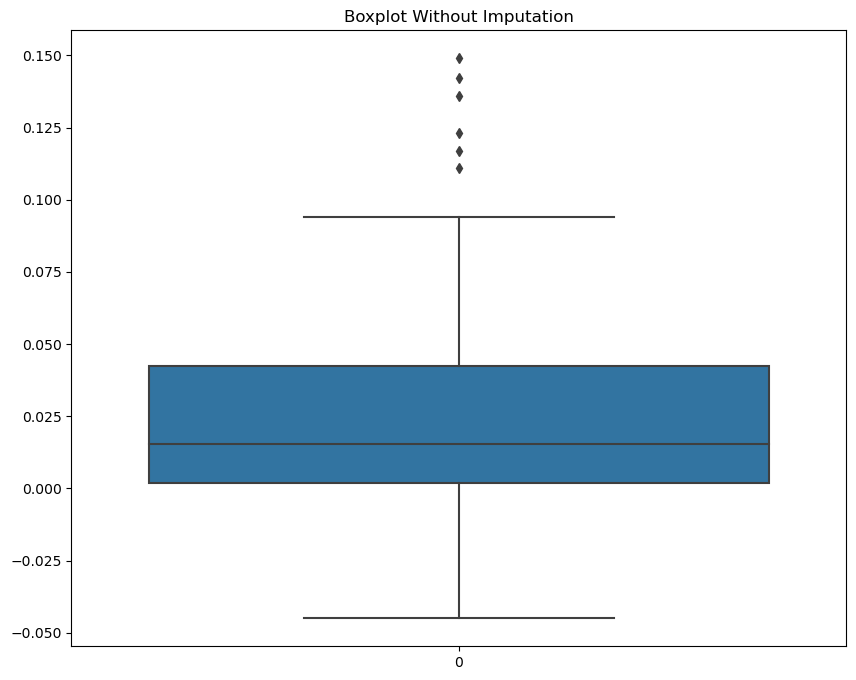

In [103]:
plt.figure(figsize=(10, 8))  # Set the size of the overall figure

# Plot Boxplot without imputations.
sns.boxplot(df_og['weighted_sentiment'])
plt.title('Boxplot Without Imputation')

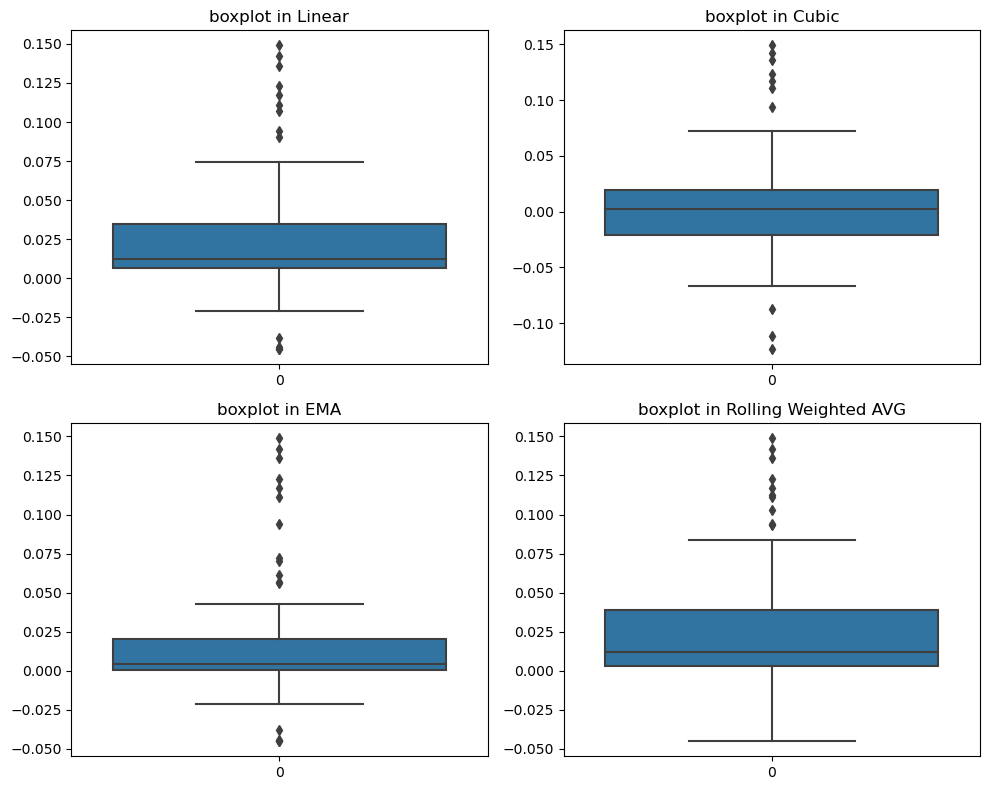

In [62]:
plt.figure(figsize=(10, 8))  # Set the size of the overall figure

# Plot for DataFrame 1
plt.subplot(2, 2, 1)  # Row 1, Column 1
sns.boxplot(pandas_df['weighted_sentiment_linear_interp'])
plt.title('boxplot in Linear')

# Plot for DataFrame 2
plt.subplot(2, 2, 2)  # Row 1, Column 2
sns.boxplot(pandas_df1['weighted_sentiment_cubic_interp'])
plt.title('boxplot in Cubic')

# Plot for DataFrame 3
plt.subplot(2, 2, 3)  # Row 2, Column 1
sns.boxplot(pandas_df2['imputed_weighted_sentiment'])
plt.title('boxplot in EMA')

# Plot for DataFrame 4
plt.subplot(2, 2, 4)  # Row 2, Column 2
sns.boxplot(pandas_df3['imputed_weighted_sentiment'])
plt.title('boxplot in Rolling Weighted AVG')

plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Display the plots

#### Boxplots

In terms of outliers the imputation techniques had a bad performance, especially for the linear, cubic and EMA where they presented a larger number of outliers on both sides of the skerwers. On the other hand, the rolling weighted avg, increase the number of outliers but, only at the side that the was already present in the original.

#### Considerations of the Analysis at this point

After analysing the imputations through fours stages, the rolling weighted average is the one that yielded better performance so far, due to:
- The lineplot showed that it did not introduced a lot of variation.
- The statistical properties stay very close to the original.
- The shape of the data remained close to the original. 
- The number of outliers increased, but in comparison with other approaches it did not generated outliers in the side that was not present in the original. 

Because time series analysis can be affected by outliers, the boxplot pointed numerous outliers in the scores (which is small already, 81). Therefore, the ultimate decision between the imputation techniques will be after applying different types of scalling (Robust Scalling, Power transformation).
- The chosen scaler techniques is because of the high variance of the data points, but also for the number of data points outside of the skewers (high number of outliers). They are more robust and less sensitive to outliers. 
- The evaluation of the techniques will be through histograms and boxplot.

#### Scalling the data

The results are displayed in the following way: 
- The results of the scalers will be displayed by imputation technique.
- The data that are going to be displayed will follow (No scaler, with RobustScaler and with PowerTransformation.
- The histogram will if the approach changed the shape of the data.
- The boxplot will focus on how the scaler handled the outliers. 

In [63]:
scaler = RobustScaler()
# Applying the transformation directly on the reshaped data
pandas_df['robust_sentiments'] = scaler.fit_transform(pandas_df['weighted_sentiment_linear_interp'].values.reshape(-1, 1))
pandas_df1['robust_sentiments'] = scaler.fit_transform(pandas_df1['weighted_sentiment_cubic_interp'].values.reshape(-1, 1))
pandas_df2['robust_sentiments'] = scaler.fit_transform(pandas_df2['imputed_weighted_sentiment'].values.reshape(-1, 1))
pandas_df3['robust_sentiments'] = scaler.fit_transform(pandas_df3['imputed_weighted_sentiment'].values.reshape(-1, 1))

In [64]:
scaler = PowerTransformer(method='yeo-johnson')
# Applying the transformation directly on the reshaped data
pandas_df['power_sentiments'] = scaler.fit_transform(pandas_df['weighted_sentiment_linear_interp'].values.reshape(-1, 1))
pandas_df1['power_sentiments'] = scaler.fit_transform(pandas_df1['weighted_sentiment_cubic_interp'].values.reshape(-1, 1))
pandas_df2['power_sentiments'] = scaler.fit_transform(pandas_df2['imputed_weighted_sentiment'].values.reshape(-1, 1))
pandas_df3['power_sentiments'] = scaler.fit_transform(pandas_df3['imputed_weighted_sentiment'].values.reshape(-1, 1))

### Scaler on linear imputation scores. 

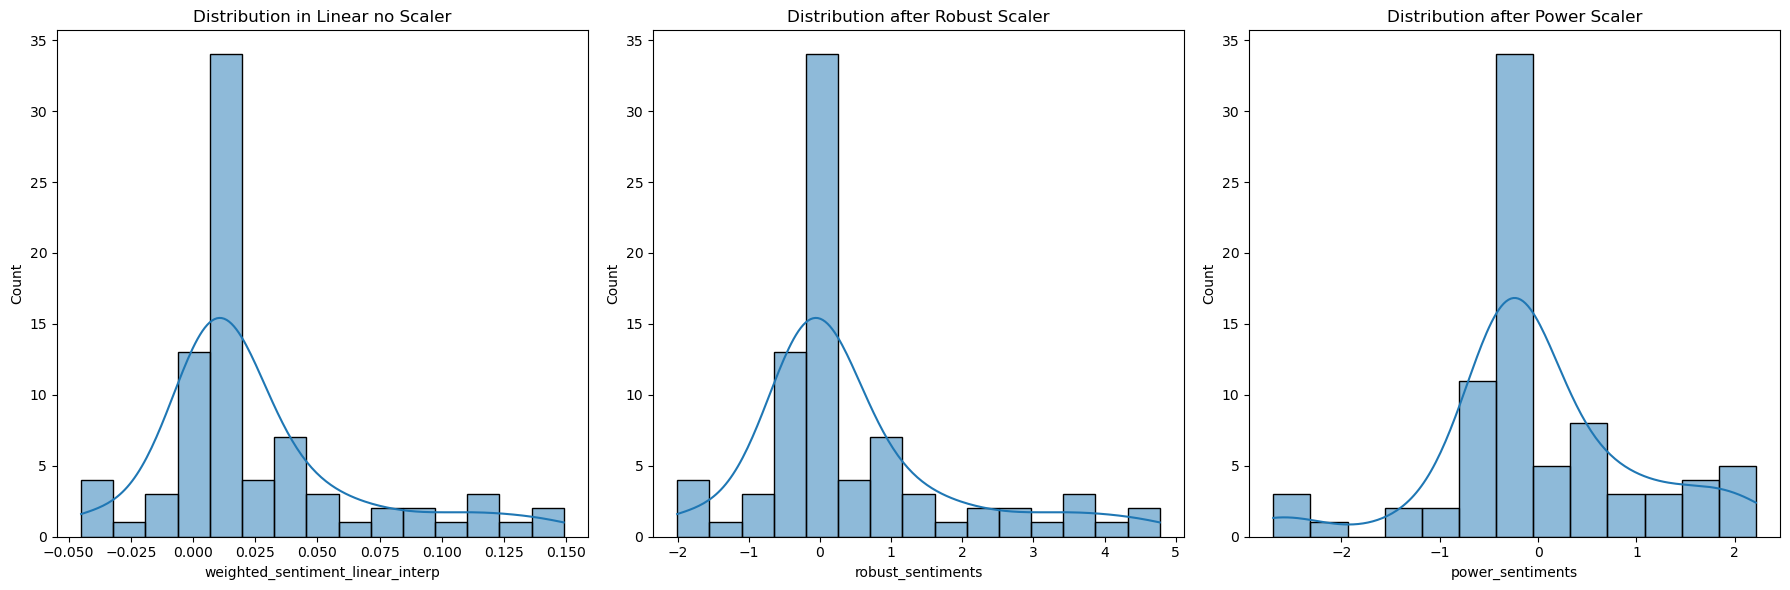

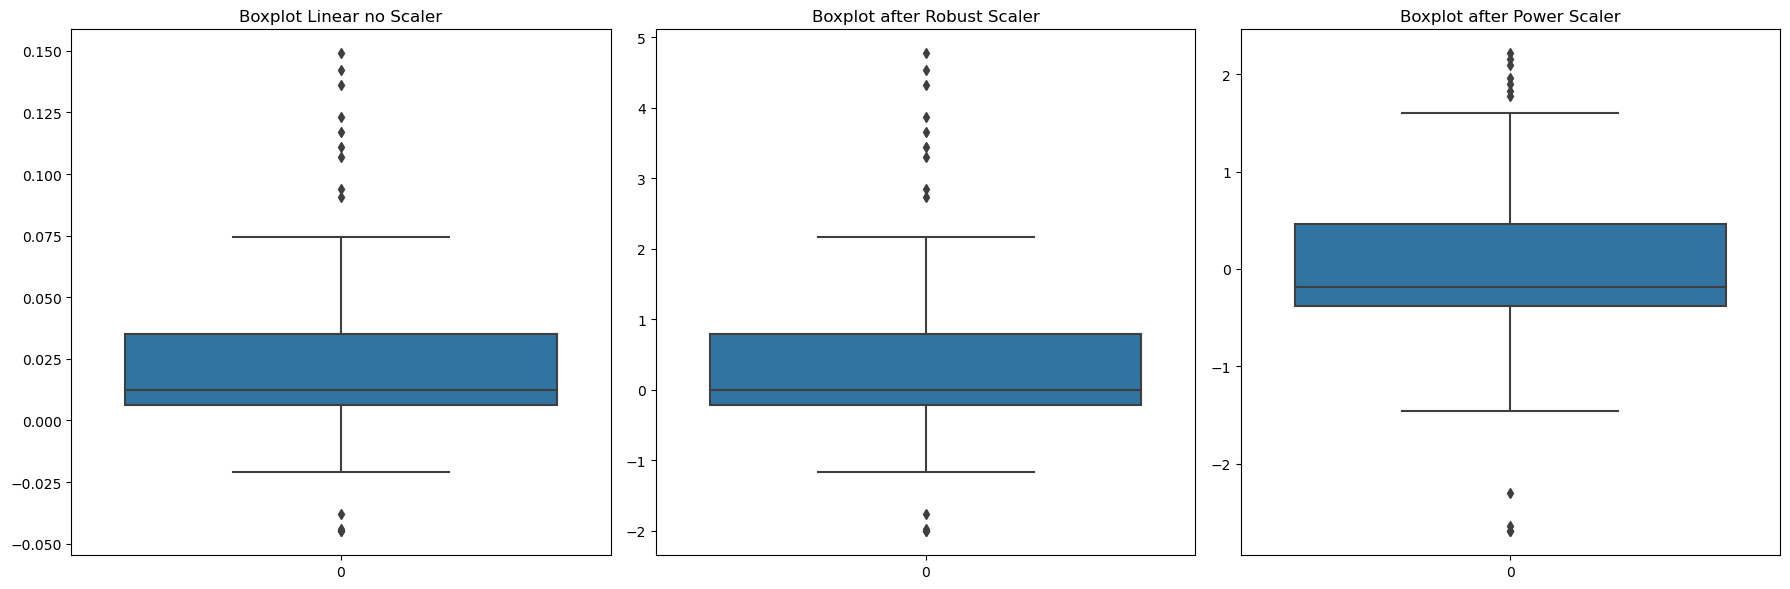

In [65]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df['weighted_sentiment_linear_interp'], kde=True)
plt.title('Distribution in Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df['robust_sentiments'], kde=True)
plt.title('Distribution after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df['weighted_sentiment_linear_interp'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

- In the linear imputation, the scaler that had most impact was the power transformation. The histogram shows that the data became more normally distributed. Although, the technique was not successful in handling the outliers.

### Scaler on cubic imputation scores. 

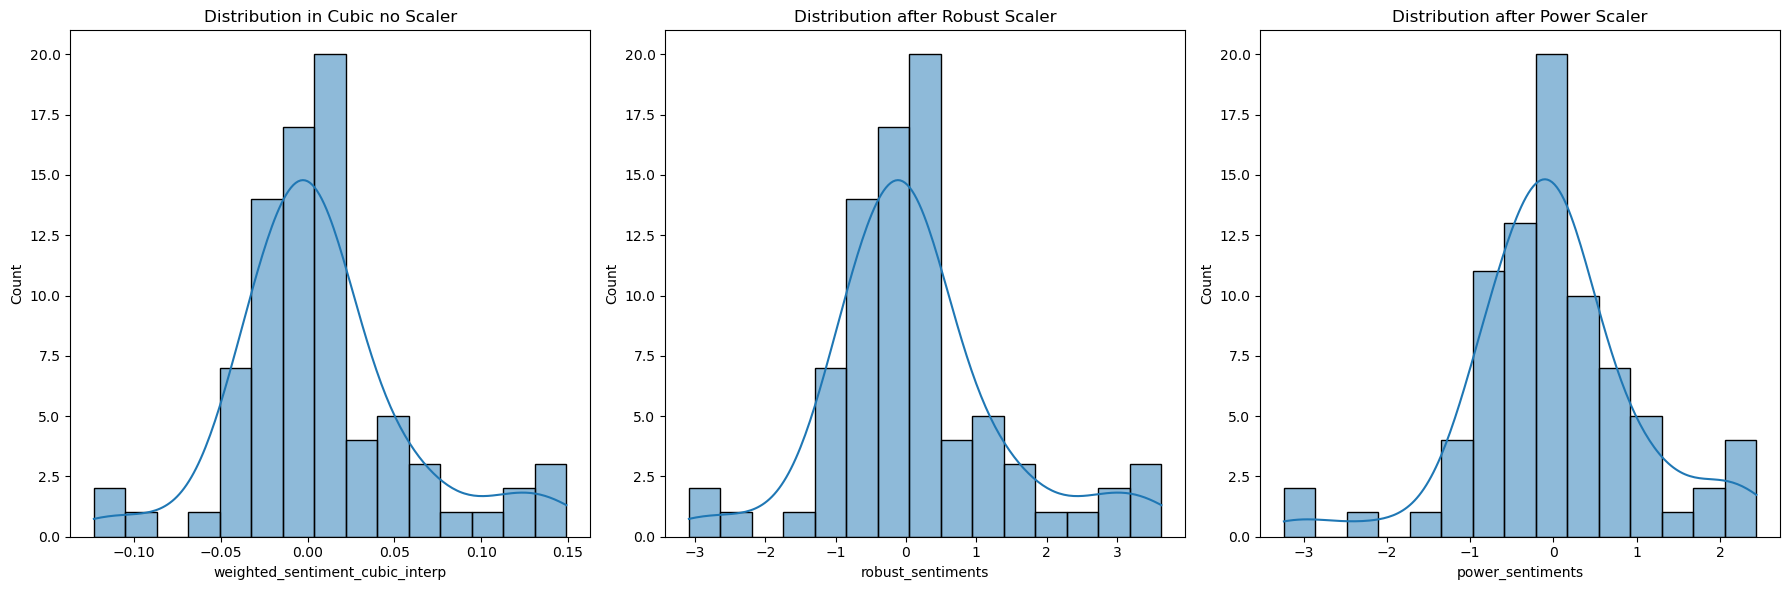

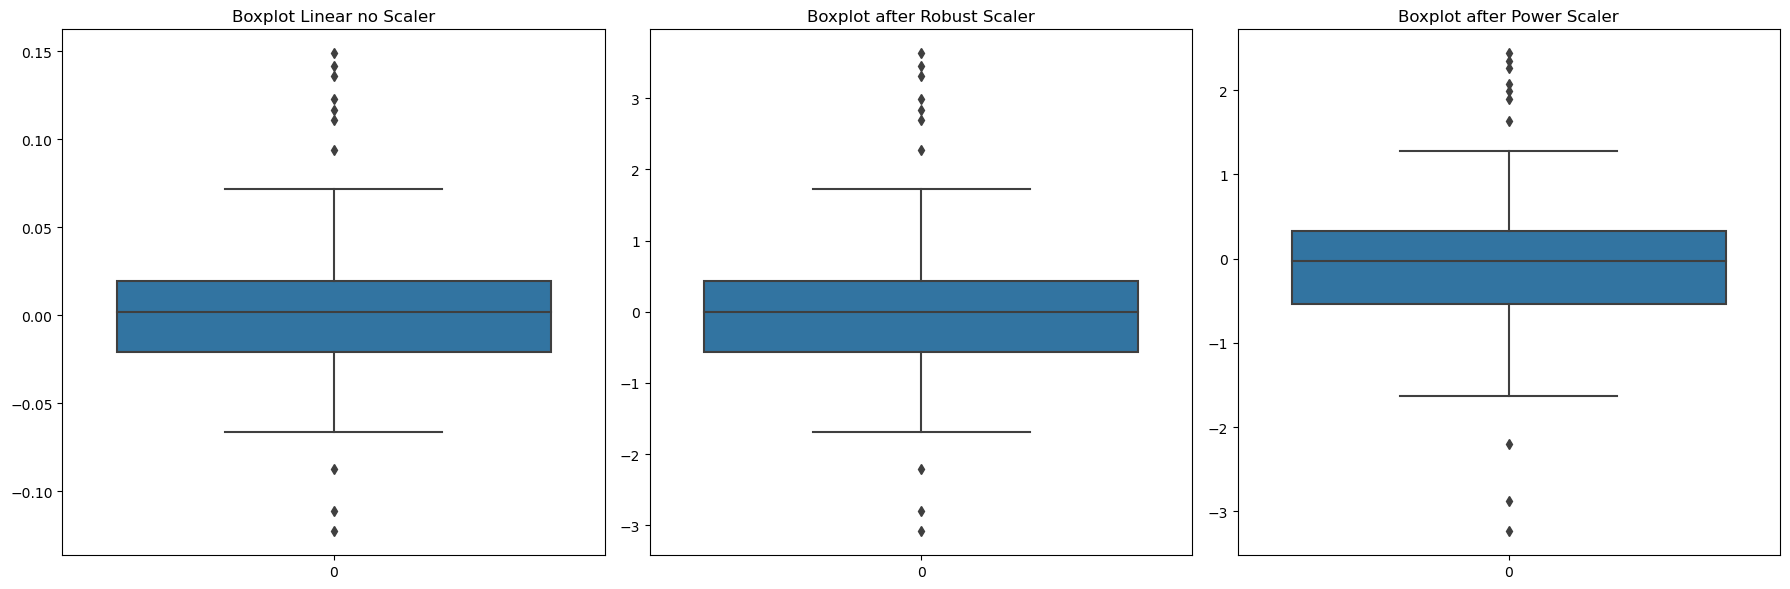

In [66]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df1['weighted_sentiment_cubic_interp'], kde=True)
plt.title('Distribution in Cubic no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df1['robust_sentiments'], kde=True)
plt.title('Distribution after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df1['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df1['weighted_sentiment_cubic_interp'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df1['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df1['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

- The approaches yielded the same results as the linear imputation regarding the outliers, both of the scalers were not able to handle the outliers using the cubic imputations. 

### Scaler on EMA imputation scores. 

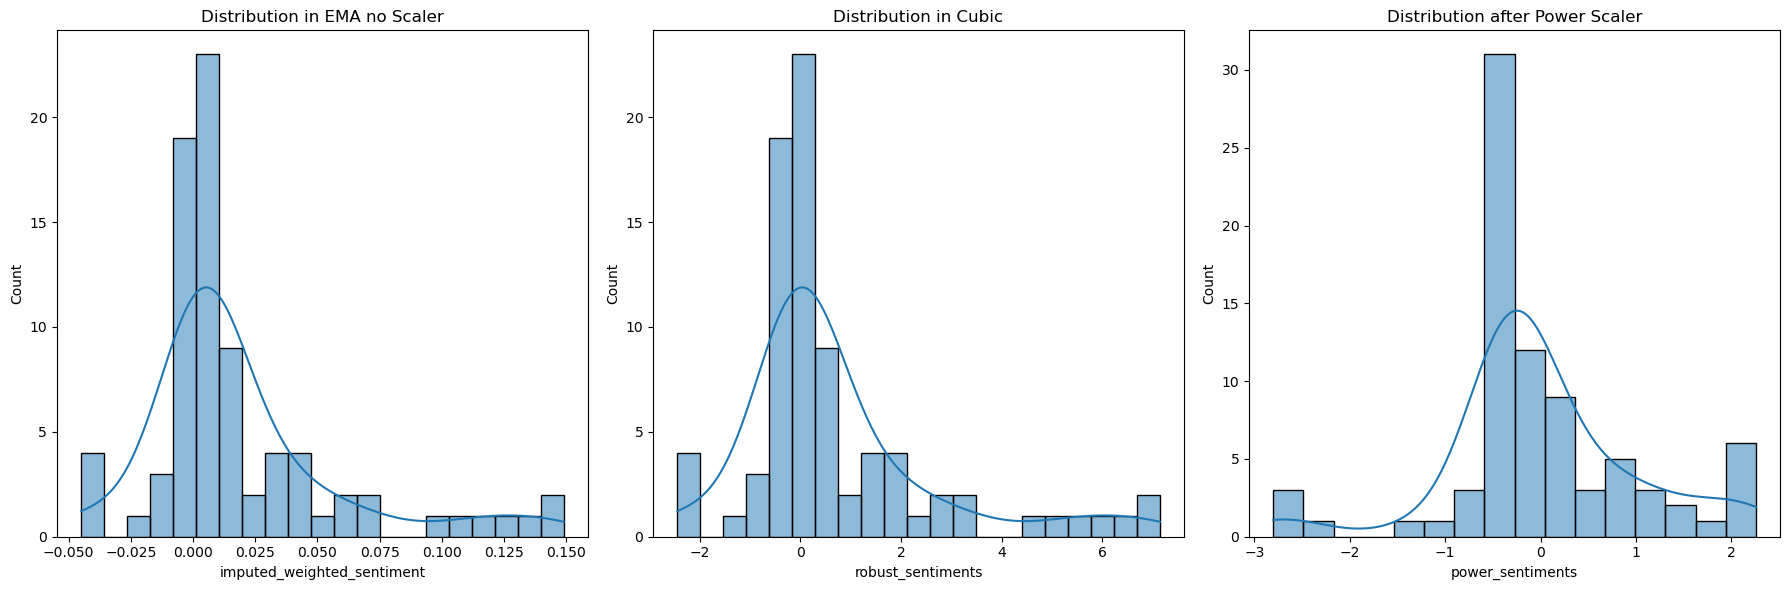

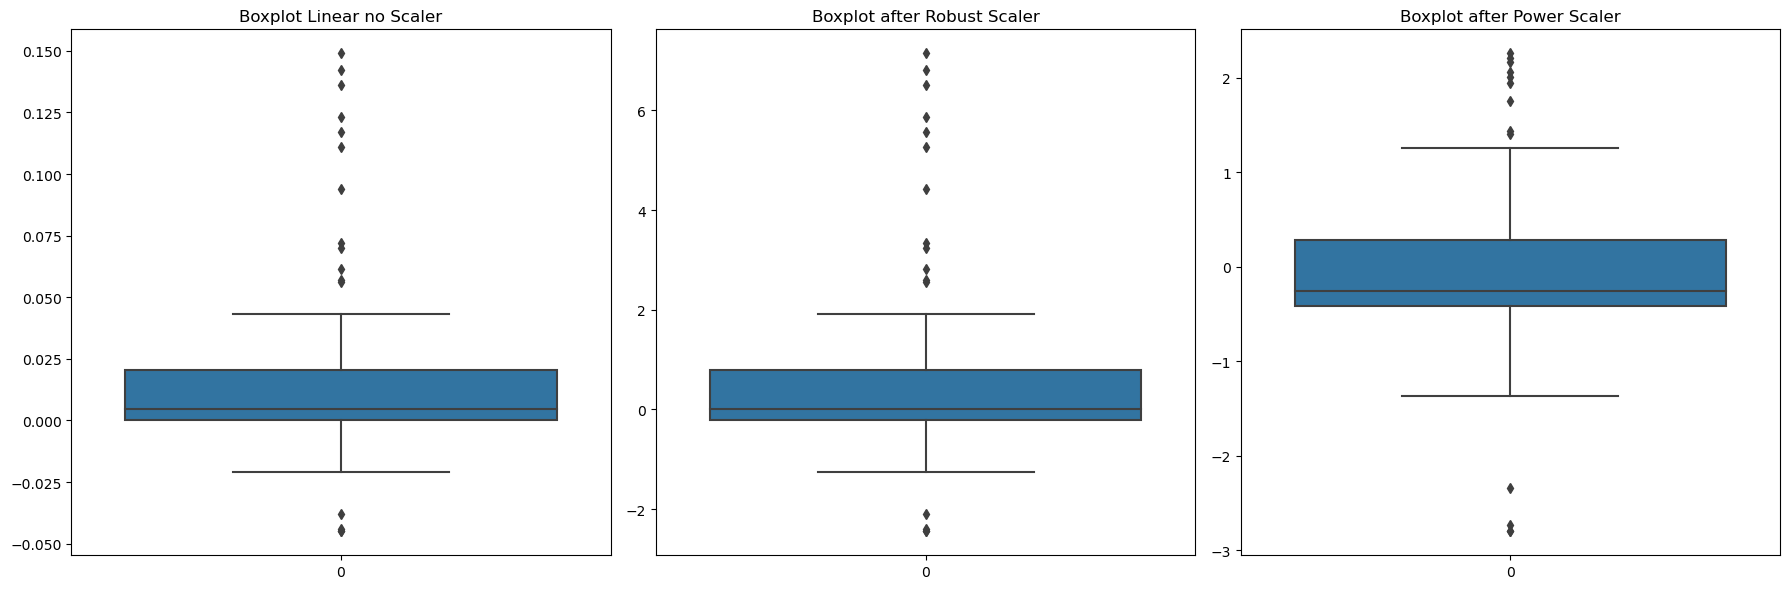

In [67]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df2['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution in EMA no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df2['robust_sentiments'], kde=True)
plt.title('Distribution in EMA after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df2['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df2['imputed_weighted_sentiment'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df2['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df2['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

- The scalers made the distribution more normally distributed. However, it did not had the effect expected to handle outliers.

### Scaler on rolling weighted avg imputation scores. 

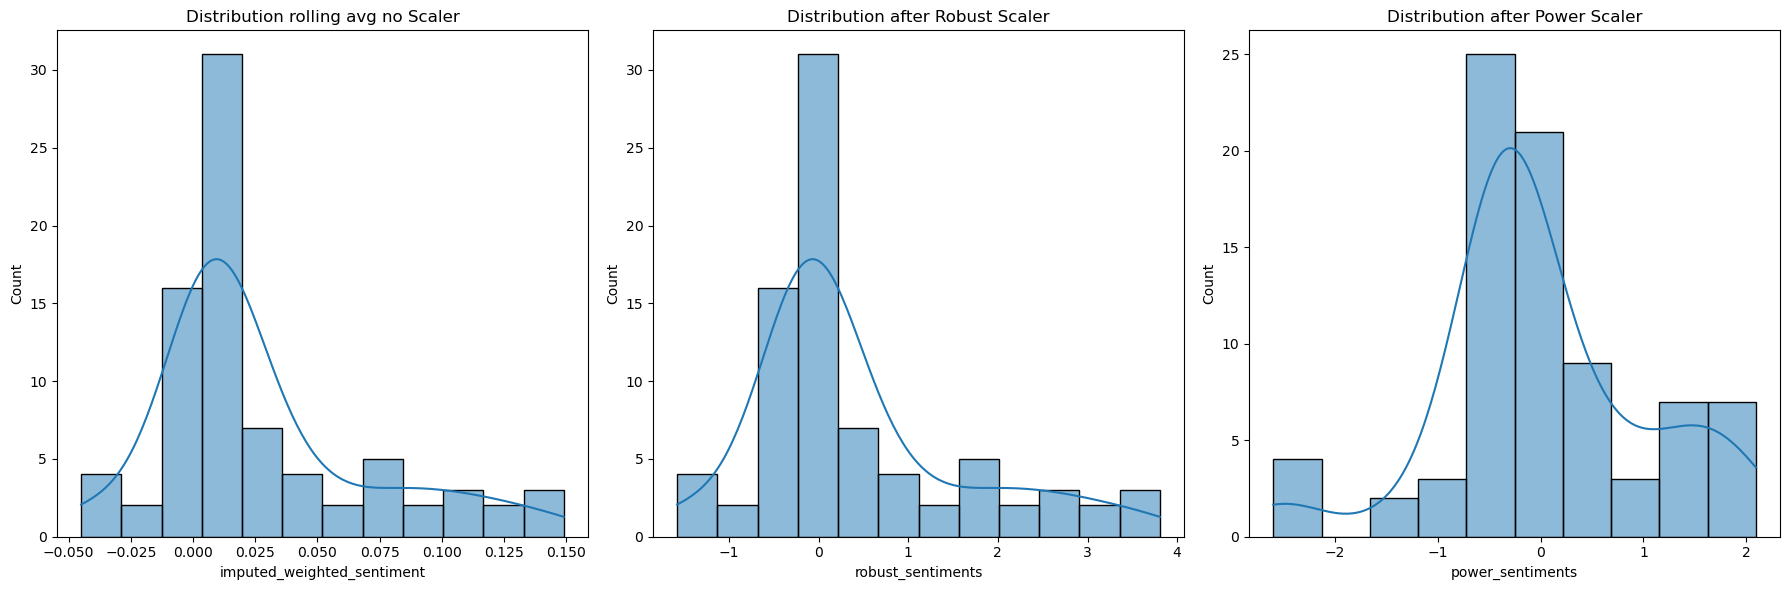

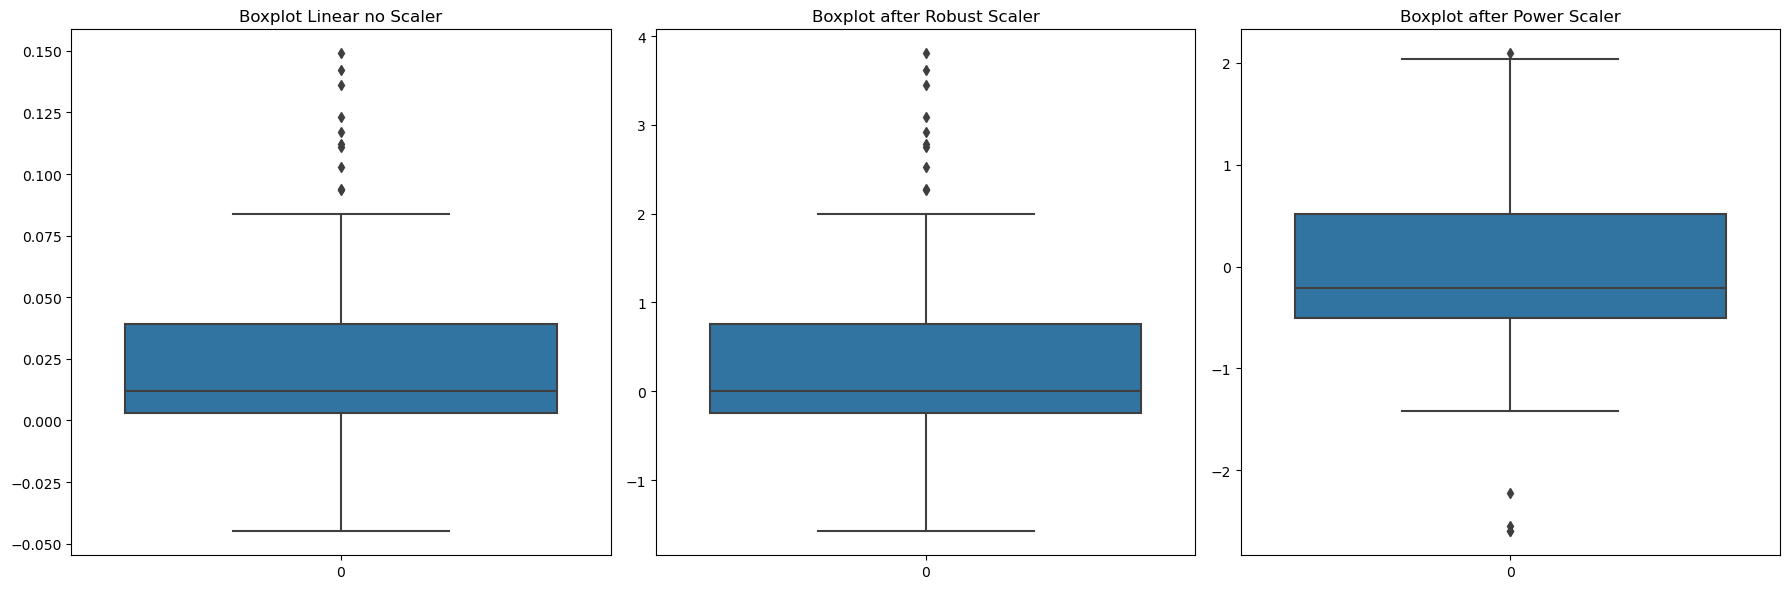

In [68]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df3['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution rolling avg no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df3['robust_sentiments'], kde=True)
plt.title('Distribution after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df3['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df3['imputed_weighted_sentiment'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df3['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df3['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

- The scalers had more impact when applied at the scores with rolling weighted avg, shifting the most frequent values to the center, making it more normally distributed. 
- Regarding the outliers, it reduced the number of outliers, but by shifting the box to the center it created outliers at the other side of the skewer, which was not present at the "original". 

#### Selecting the techniques

The selection of the approaches combined is the Rolling Weighted Average and scalling with the PowerTransformer. The reasons is because the imputation technique resulted in few variations, but the statistical properties remained close to the original.
Meanwhile, the scalling approach was chosen due to the normalization of the data, but mainly considering the reduction of outliers. 

#### The data to be used in time series analysis in the power_sentiments, which is the overall sentiment scores

Transformations occured to the scores since the polarity extraction:
- Weighted Average (Daily Aggregation);
- Imputation using Rolling Weighted Average; 
- Power Transformer Scaler; 

## Time-Series Analysis

Among different approaches to apply time series, the chosen one is the auto regressives.
- Straightfoward to implement.
- Daily sentiments coould be correlated, a feature that the approach performs well. 
- Known to yield good results when forecasting.

In [69]:
final_df = pandas_df3
final_df.head()

,daily_records,weight,weighted_sentiment,imputed_weighted_sentiment,robust_sentiments,power_sentiments
0,2009-04-06,0.030010,0.003,0.003000,-0.244884,-0.499354
1,2009-04-07,0.155140,0.016,0.016000,0.115806,-0.088417
2,2009-04-08,0.171115,NaN,0.007220,-0.127795,-0.359835
3,2009-04-09,0.171115,NaN,0.004877,-0.192793,-0.436527
4,2009-04-10,0.171115,NaN,0.003683,-0.225945,-0.476369


In [71]:
final_df = final_df.drop(['weight', 'weighted_sentiment', 'imputed_weighted_sentiment', 'robust_sentiments'], axis=1)

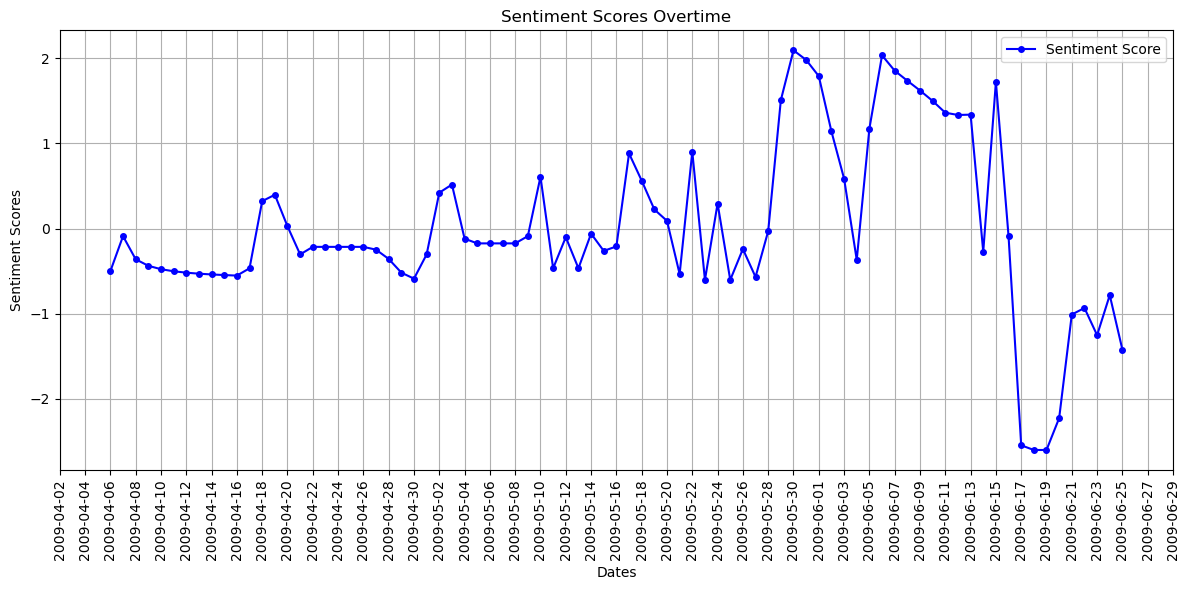

In [104]:
# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(final_df['daily_records'], final_df['power_sentiments'], label='Sentiment Score', marker='o', markersize=4, color='blue')
plt.xlabel('Dates')
plt.ylabel('Sentiment Scores')
plt.title('Sentiment Scores Overtime')
plt.legend()
plt.grid(True)

# Set x-axis to show all the recorded dates. 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Shows a date every 2 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Type of the date to be shown
 # Increases readability.
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- With all the gaps filled the next step is to investigate seasonality and trends in the sentiment scores overtime. But, through the line plot it is not observable trends or seasonality, thus performing the seasonal decompose to futher analyse its composition.

In [73]:
# Ensures the series is indexed by time.
final_df.index = pd.date_range(start='2009-04-06', periods=len(final_df), freq='D')


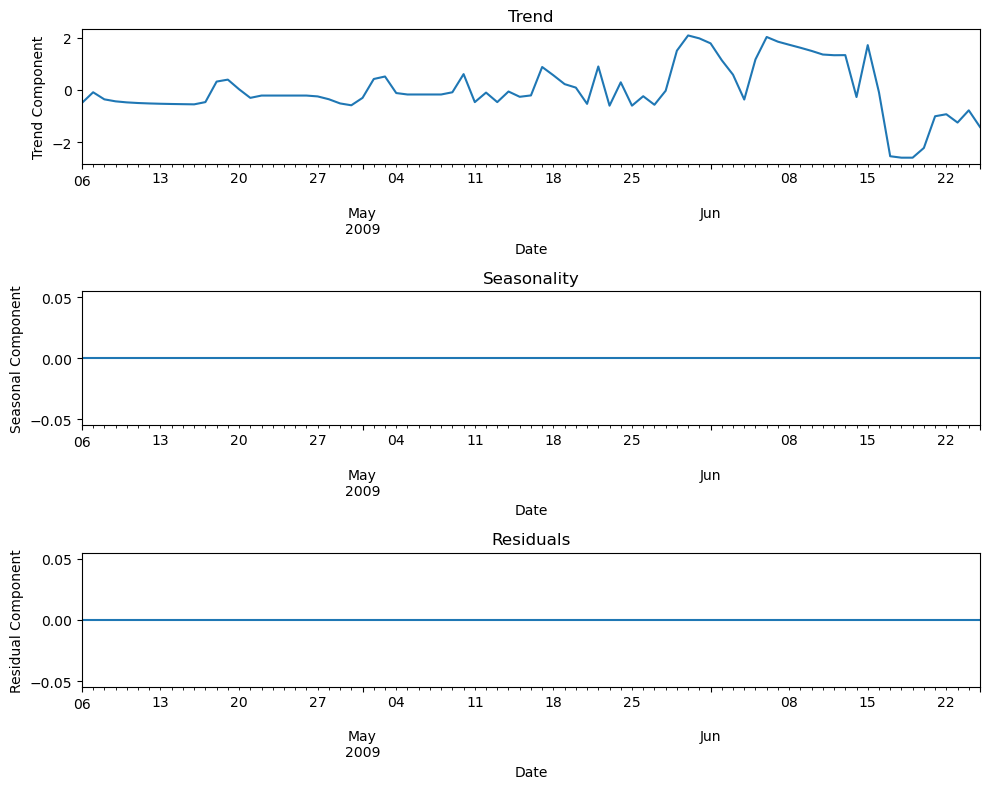

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the time series
decomposition = seasonal_decompose(final_df['power_sentiments'], 
                                   model='additive', 
                                   period=1,  # Assuming no known seasonality period from the sample
                                   extrapolate_trend='freq')

# Plotting the components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trend Component')

decomposition.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
ax2.set_xlabel('Date')
ax2.set_ylabel('Seasonal Component')

decomposition.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual Component')

plt.tight_layout()
plt.show()

In [75]:
# Augmented Dickey-Fuller test
adf_test = adfuller(final_df['power_sentiments'], autolag='AIC')

adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result

{'Test Statistic': -3.113511080309918,
 'p-value': 0.025569331746229395,
 'Lags Used': 0,
 'Number of Observations Used': 80,
 'Critical Values': {'1%': -3.5148692050781247,
  '5%': -2.8984085156250003,
  '10%': -2.58643890625}}

- The ADFuller test resulted in p value below 0.05, rejecting the null hypothesis, thus indicating stationarity.
- The test also shows that the statistic value is bellow the value of 5% (critical value), having 85% certainty of stationary.

<Figure size 1400x700 with 0 Axes>

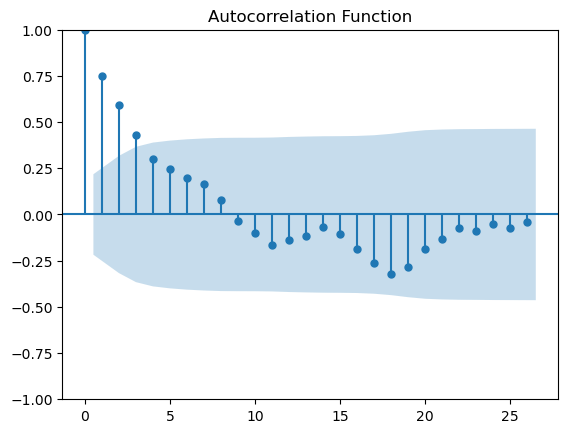

<Figure size 1400x700 with 0 Axes>

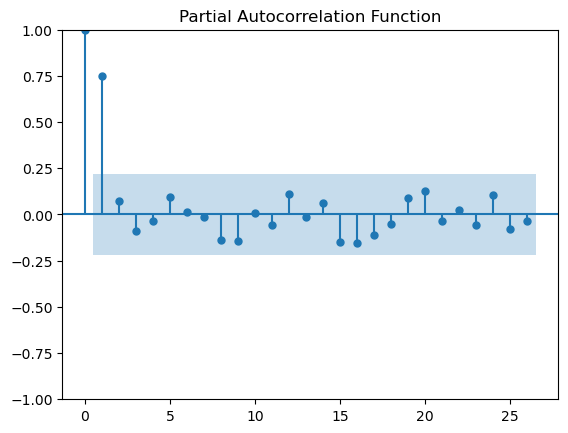

In [76]:
# rule of thumb (round 1/3 of observations) for 80 observations
n_lags = int(80 / 3)

# Plot the ACF
plt.figure(figsize=(14, 7))
plot_acf(final_df['power_sentiments'], lags=n_lags, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

# Plot the PACF
plt.figure(figsize=(14, 7))
plot_pacf(final_df['power_sentiments'], lags=n_lags, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function')
plt.show()



- The ACF shows correlations correlation in many lags, but also the same decreases slowly to the confidence interval limits, indicating that the data could be non-stationary.
- Based on the PACF plt it shows that after the first lag (0.75) it went straight down to the confidence of interval and indicates that a value of 1 for auto regressive (AR) can be a reasonable starting point for time series model.  

The analysis so far leads to differencing the sentiment scores, the ADF tests indicates stationarity, although the ACF presentes signs of non-stationarity, the diff technique will be performed to apply the data to Auto Regressive models. Such as AR, ARMA (with Moving Average) and ARIMA (With Integrated - Differencing).
- To analyse the impact of the differencing few attempts on the scores with and without the approach will be performed. 

#### Differenced sentiment scores

In [117]:
# Differencing the sentiment scores
diff_df = final_df['power_sentiments'].diff(1)  # First difference

# To remove NaN values, the approach will generate the first observation to be NaN value.
diff_df = diff_df.dropna()

In [118]:
diff_df.head()

2009-04-07    0.410936
2009-04-08   -0.271417
2009-04-09   -0.076692
2009-04-10   -0.039842
2009-04-11   -0.024405
Freq: D, Name: power_sentiments, dtype: float64

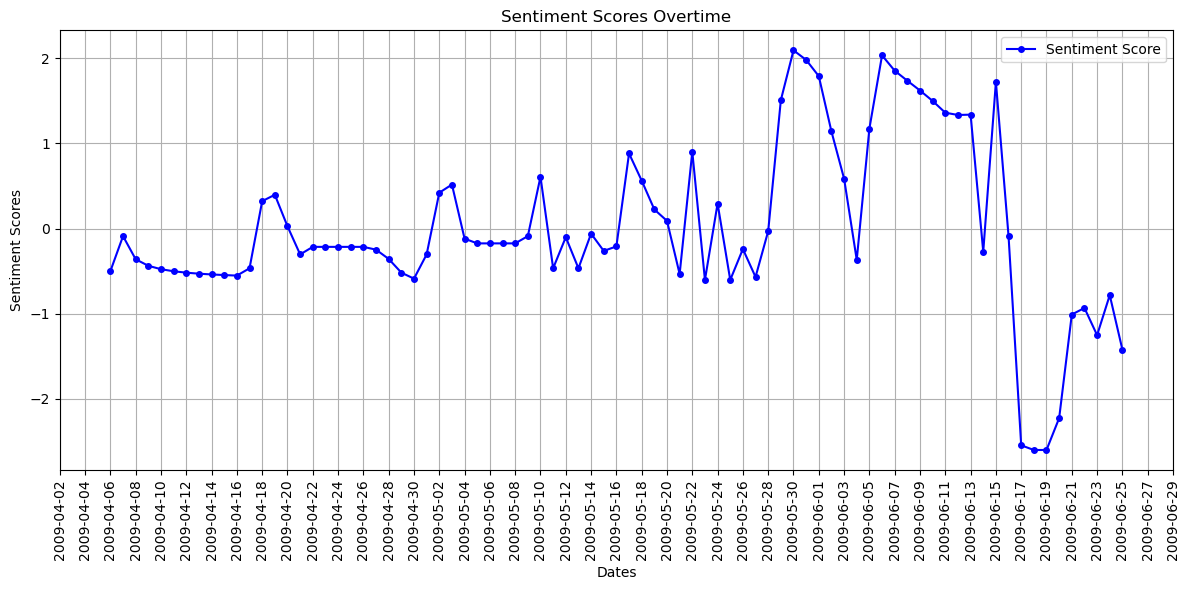

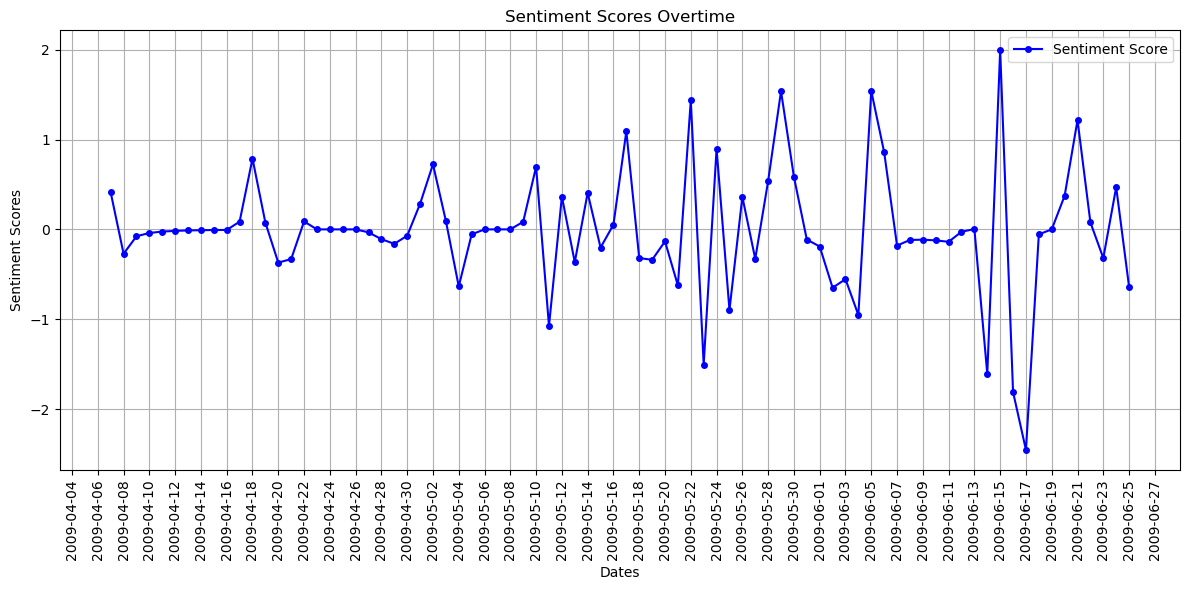

In [170]:
# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(final_df['daily_records'], final_df['power_sentiments'], label='Sentiment Score', marker='o', markersize=4, color='blue')
plt.xlabel('Dates')
plt.ylabel('Sentiment Scores')
plt.title('Sentiment Scores Overtime')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Shows a date every 2 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Type of the date to be shown
 # Increases readability.
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(diff_df, label='Sentiment Score', marker='o', markersize=4, color='blue')
plt.xlabel('Dates')
plt.ylabel('Sentiment Scores')
plt.title('Sentiment Scores Overtime')
plt.legend()
plt.grid(True)

# Set x-axis to show all the recorded dates. 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Shows a date every 2 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Type of the date to be shown
 # Increases readability.
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- The plot shows that the differencing made the line change, visually it added more seasonality to the data, there more ups and downs than before. 

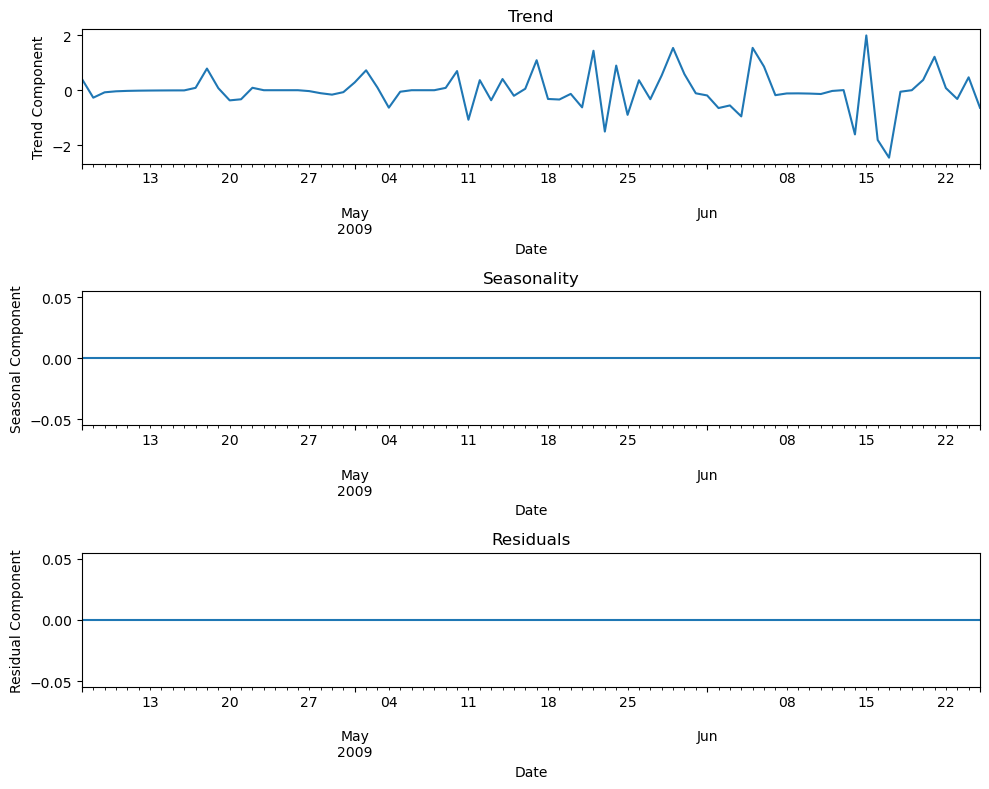

In [171]:
# Decomposing the time series
decomposition = seasonal_decompose(diff_df, 
                                   model='additive', 
                                   period=1,  # Assuming no known seasonality period from the sample
                                   extrapolate_trend='freq')

# Plotting the components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trend Component')

decomposition.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
ax2.set_xlabel('Date')
ax2.set_ylabel('Seasonal Component')

decomposition.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual Component')

plt.tight_layout()
plt.show()

- As before the .diff, the scores do not present any trend, also do not have seasonalities. 

In [172]:
# Augmented Dickey-Fuller test
adf_test = adfuller(diff_df, autolag='AIC')

adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result

{'Test Statistic': -10.448356786604966,
 'p-value': 1.4600237580065286e-18,
 'Lags Used': 0,
 'Number of Observations Used': 79,
 'Critical Values': {'1%': -3.5159766913976376,
  '5%': -2.898885703483903,
  '10%': -2.5866935058484217}}

The differenced sentiment scores is statiornary.

- The differencing decreased the statistic value from -3.11 to -10.45, which made the value to become lower than all the critical values (it was not without applying diff).
- P-value is now way lower than 0.05. 

<Figure size 1400x700 with 0 Axes>

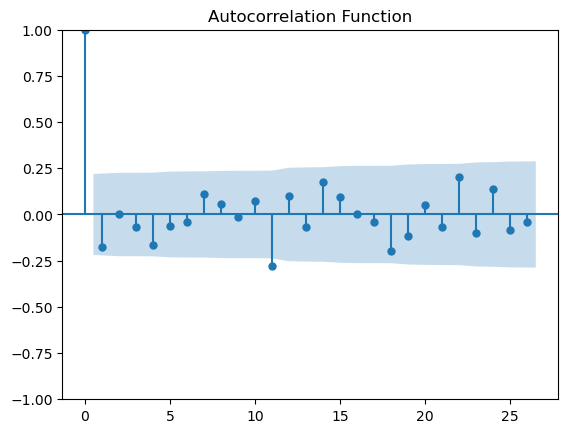

<Figure size 1400x700 with 0 Axes>

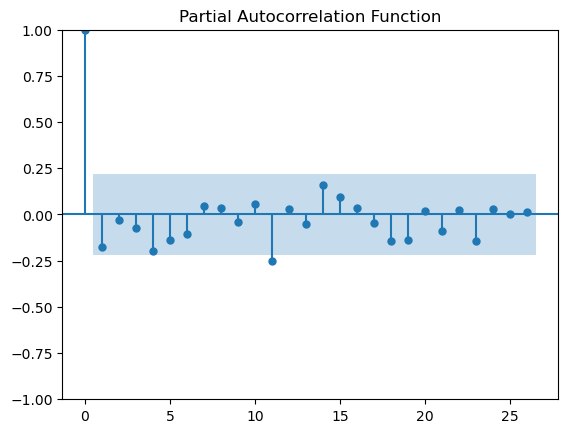

In [173]:
# rule of thumb (round 1/3 of observations) for 80 observations
n_lags = int(80 / 3)

# Plot the ACF
plt.figure(figsize=(14, 7))
plot_acf(diff_df, lags=n_lags, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

# Plot the PACF
plt.figure(figsize=(14, 7))
plot_pacf(diff_df, lags=n_lags, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function')
plt.show()

- Both ACF and PACF shows that the scores falls inside the confidence of interval after the first lag, which can support even further the stationarity.
- Also, datapoints are not correlated like it was before applying .diff.

#### Spliting the data into train and test. 

- The train set will be composed of 90% and the test 10%, which is the "limit" of standard practise as discuss in class, the decision of 10% is also based on the fact the the dataset has a small number of observations.
- Two splits, with differencing and without it. Rationale for the differencing will be given at the end of the Auto Regressive model steps, because it will also support the approach. 

In [77]:
# Split the data into train and test sets
train_size = int(len(final_df) * 0.9)
train, test = final_df[0:train_size], final_df[train_size:]

In [119]:
# Split the data into train and test sets
train_size = int(len(diff_df) * 0.9)
train_diff, test_diff = diff_df[0:train_size], diff_df[train_size:]

### Auto Regressive 

In [78]:
# Fit an AR(1) model
model = AutoReg(train['power_sentiments'], lags=1)
model_fit = model.fit()
    
# Summary of the model
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                     AutoReg(1)   Log Likelihood                 -63.774
Method:               Conditional MLE   S.D. of innovations              0.594
Date:                Tue, 14 Nov 2023   AIC                            133.549
Time:                        08:53:48   BIC                            140.337
Sample:                    04-07-2009   HQIC                           136.248
                         - 06-16-2009                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0768      0.073      1.052      0.293      -0.066       0.220
power_sentiments.L1     0.6734      0.087      7.740      0.000       0.503       0.844
                

- Using 1 lag the model yield an AIC of 133.55

MSE: 3.9535175156355473
RMSE: 1.988345421609522
MAE: 1.8696820995855066


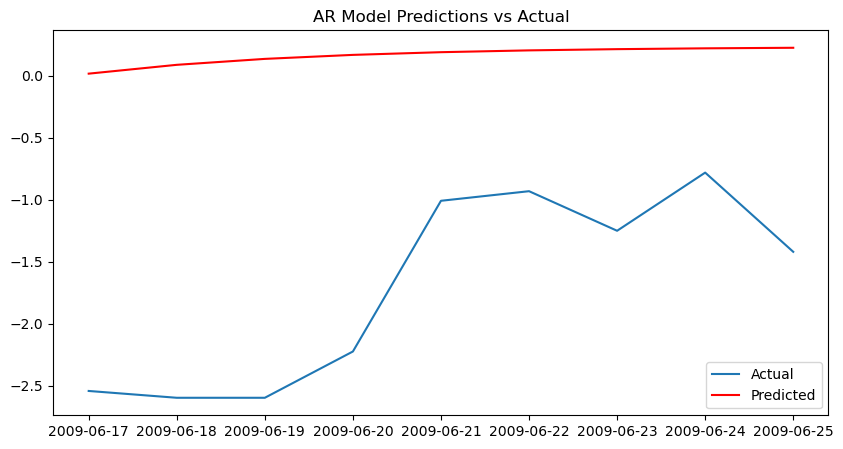

In [79]:
# Make predictions
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end, dynamic=False)

# Calculate metrics
mse = mean_squared_error(test['power_sentiments'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['power_sentiments'], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test['power_sentiments'], label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.legend()
plt.title('AR Model Predictions vs Actual')
plt.show()

- Based in the scale of the scores the mse, rmse and mae metrics are high so as the AIC, therefore the model needs adjustments. Thus, a algorithm to find an optmal value based on three metric, MSE, AIC and BIC.  

In [140]:
# Define the range of lags to test
lag_values = range(1, 10)  # testing lags 1 to 9
aic_values = []
bic_values = []
mse_values = []

for lag in lag_values:
    model = AutoReg(train_diff, lags=lag)
    model_fit = model.fit()
    aic_values.append(model_fit.aic)
    bic_values.append(model_fit.bic)
    

for lag in lag_values:
    model1 = AutoReg(train_diff, lags=lag)
    model_fit1 = model1.fit()
    predictions = model_fit1.predict(start=lag, end=len(train_diff)-1, dynamic=False)
    mse = mean_squared_error(train_diff[lag:], predictions)
    mse_values.append(mse)

# Sort the lag values based on AIC, BIC, and MSE and get the top 3 for each criterion
sorted_lags_by_aic = sorted(zip(aic_values, lag_values))[:3]
sorted_lags_by_bic = sorted(zip(bic_values, lag_values))[:3]
sorted_lags_by_mse = sorted(zip(mse_values, lag_values))[:3]

# Extract the top 3 lag values for each criterion
top_3_aic = [lag for aic, lag in sorted_lags_by_aic]
top_3_bic = [lag for bic, lag in sorted_lags_by_bic]
top_3_mse = [lag for mse, lag in sorted_lags_by_mse]

# Print the top 3 lag values based on AIC, BIC, and MSE
print(f'Top 3 Lags by AIC: {top_3_aic}')
print(f'Top 3 Lags by BIC: {top_3_bic}')
print(f'Top 3 Lags by MSE: {top_3_mse}')    

Top 3 Lags by AIC: [9, 6, 8]
Top 3 Lags by BIC: [1, 2, 3]
Top 3 Lags by MSE: [9, 6, 8]


                            AutoReg Model Results                             
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                     AutoReg(7)   Log Likelihood                 -67.999
Method:               Conditional MLE   S.D. of innovations              0.689
Date:                Tue, 14 Nov 2023   AIC                            153.999
Time:                        15:00:36   BIC                            173.568
Sample:                    04-14-2009   HQIC                           161.720
                         - 06-17-2009                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0084      0.087     -0.096      0.924      -0.179       0.163
power_sentiments.L1    -0.3213      0.157     -2.043      0.041      -0.629      -0.013
power_sentiments

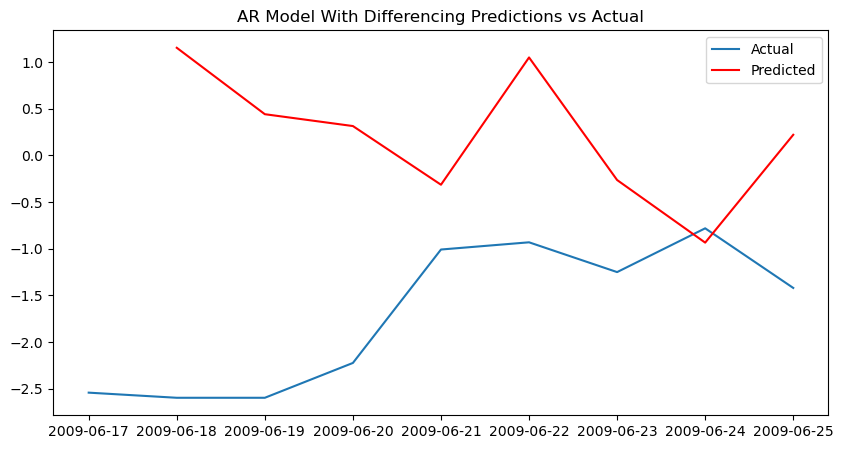

In [143]:
# Fit an AR(7) model
model3 = AutoReg(train_diff, lags=7)
model_fit3 = model3.fit()
    
# Summary of the model
print(model_fit3.summary())

# Make predictions
start = len(train_diff)
end = len(train_diff) + len(test_diff) - 1
predictions = model_fit3.predict(start=start, end=end, dynamic=False)

# Calculate metrics
mse = mean_squared_error(test_diff, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_diff, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test['power_sentiments'], label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.legend()
plt.title('AR Model With Differencing Predictions vs Actual')
plt.show()

- Despite trying all the values provided parameter tunning algorithm, by attempting other values the lags = 7 is the that yields the best results when taking into consideration both metrics, the AIC (154) and MSE (0.96). 
- Also, the lineplot had a significant weight to decide the number of lags. 

- To check "how good" the model was fitted, a analysis of residuals will be performed in the AR with 7 lags. 

#### Residuals of AR

In [195]:
# Get the residuals of the model for analysis.
residuals_ar = model_fit3.resid

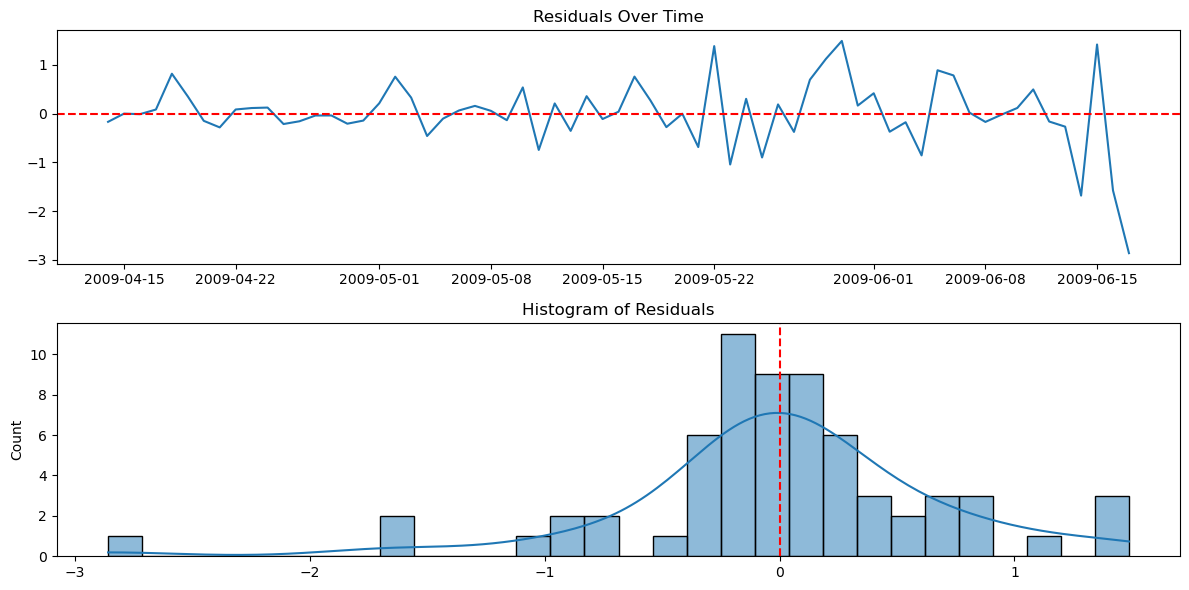

In [197]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title('Residuals Over Time')
plt.plot(residuals_ar)
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(212)
plt.title('Histogram of Residuals')
sns.histplot(residuals_ar, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
# Shapiro-Wilk test for normality
shapiro_stat, shapiro_pvalue = stats.shapiro(residuals_ar)
print(f'Shapiro-Wilk test statistic: {shapiro_stat}')
print(f'Shapiro-Wilk test p-value: {shapiro_pvalue}')

- Looking at the residuals:
1. Overtime: Positive side is that it does not have any pattern and trend, however fluctuations are present (values way above 0). 
2. Histogram: It is slightly left-skewed (longer curve to the left).

#### Differencing selection 

- The chosen models to compare was selected by searching lags through algorithms and try and error. 
- Based on the Auto Regressive model, the differencing approach made a significant impact. 

|       | No Diff | With Diff|
|-------|---------|----------|
|  MSE  |   6.42  |   0.96   |
|  RMSE |   2.53  |   0.98   |
|  MAE  |   2.36  |   0.82   |
|  AIC  |  121.48 |  153.99  |
|  BIC  |  145.05 |  173.57  |

- The AIC and BIC scores in the diff set are higher, however the error values were much lower than the other and by balcing out the results, therefore applying differencing is necessary. 
- Sentiment scores to be used in the following models will contain a first differecing to ensure equality when evaluating each model. 
- The optimal value for lags is 7, the value was found by attempting many values (only one parameter, so it is feasiable), despite the algorithm found that 9 is the best value. Therefore, the AR(7) is the selected model for comparison against other approaches. 

### Auto Regressive Moving Average (ARMA)

In [ ]:
p = 1 # (from PACF) # Both p and q enters the interval after the first lag, so they are going to be the 
q = 1 # (from ACF)  # the starting point for the ARMA model.
d = 0 # The time series is stationary, so d is 0.

# Fit the ARMA model using the training data.
model = ARIMA(train_diff, order=(p, d, q))
model_fit = model.fit()

# Print out the summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train_diff), end=len(train_diff) + len(test_diff) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_diff, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test_diff, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_diff, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

- After the model was trained using the parameters based on the ACF and PACF, a grid search will search for optimal parameters between a range of 0 to 9 and the metrics that will be based upon are the MSE and AIC.
- The parameters generated by the codes will be used to attempt to chose the best order based on the balance between MSE, AIC, and visually (line plot).

In [151]:
# Define the range of values for p and q to try (0-9).
p_range = range(9) 
q_range = range(9)  
aic_values = []

# Grid search over p_range and q_range
for p in p_range:
    for q in q_range:
        try:
            # Fit the ARMA model with the current p and q values
            model = ARIMA(train_diff, order=(p, 0, q))
            model_fit = model.fit()
            # Append the order and AIC to the list
            aic_values.append((model_fit.aic, (p, q)))
        except:  # Catching all exceptions is not best practice, but useful for illustration
            continue

# Sort the list of AIC values in ascending order (the lower the better)
aic_values.sort()

# Get the top 5 models with the lowest AIC values
top_5_models = aic_values[:5]

print("Top 5 ARMA models by AIC:")
for model_aic, order in top_5_models:
    print(f'ARMA{order} with AIC: {model_aic}')


Top 5 ARMA models by AIC:
ARMA(1, 8) with AIC: 151.56225710947376
ARMA(2, 8) with AIC: 152.04972877283268
ARMA(0, 7) with AIC: 152.06942755725404
ARMA(0, 8) with AIC: 152.55086696111584
ARMA(6, 4) with AIC: 153.28006563685526


In [150]:
# Define the range of values for p and q to try
p_range = range(9)
q_range = range(9)
mse_values = []

# Grid search over p_range and q_range
for p in p_range:
    for q in q_range:
        try:
            # Fit the ARMA model with the current p and q values
            model = ARIMA(train_diff, order=(p, 0, q))
            model_fit = model.fit()
            
            # Make predictions on the test set
            start = len(train_diff)
            end = start + len(test_diff) - 1
            predictions = model_fit.predict(start=start, end=end)
            
            # Calculate MSE and append to list
            mse = mean_squared_error(test_diff, predictions)
            mse_values.append((mse, (p, q)))
        except:  # This is a catch-all except, which is not best practice
            continue

# Sort the list of MSE values in ascending order (the lower the better)
mse_values.sort()

# Get the top 5 models with the lowest MSE values
top_5_models = mse_values[:5]

print("Top 5 ARMA models by MSE:")
for mse, order in top_5_models:
    print(f'ARMA{order} with MSE: {mse}')


Top 5 ARMA models by MSE:
ARMA(0, 0) with MSE: 0.3036183147062904
ARMA(5, 0) with MSE: 0.33611595653083304
ARMA(1, 0) with MSE: 0.34611988684530115
ARMA(0, 1) with MSE: 0.39450041778367284
ARMA(2, 0) with MSE: 0.3967326059750959


- It was attempted the parameters provided by the algorithm and the one which balanced the scores of AIC and MSE was the (5,0) with MSE of 0.33 and AIC of 162.

                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 -74.230
Date:                Tue, 14 Nov 2023   AIC                            162.460
Time:                        17:10:09   BIC                            178.397
Sample:                    04-07-2009   HQIC                           168.804
                         - 06-17-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0078      0.058     -0.135      0.893      -0.121       0.106
ar.L1         -0.3252      0.114     -2.863      0.004      -0.548      -0.103
ar.L2         -0.1675      0.156     -1.074      0.2

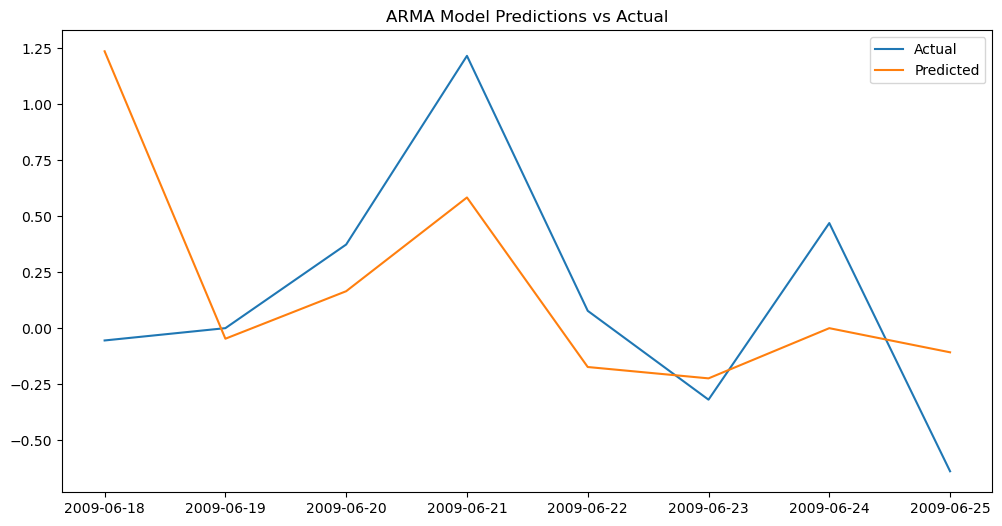

MSE: 0.33611595653083304
RMSE: 0.5797550832298352
MAE: 0.4408473111092057


In [190]:
# Order based on the grid search.
p = 5 
q = 0 
d = 0 # The time series is stationary, so d is 0

# Fit the ARMA model using the training data
model = ARIMA(train_diff, order=(p, d, q))
model_fit = model.fit()

# Print out the summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train_diff), end=len(train_diff) + len(test_diff) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_diff, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test_diff, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_diff, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

- By observivng the predicted values, the model enhanced its predictions in comparison to the Auto Regressive Approach. 

#### Residuals of ARMA (5,0)

In [191]:
# Get the residuals of the model for analysis.
residuals_arma = model_fit.resid

In [193]:
from scipy import stats

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_pvalue = stats.shapiro(residuals_arma)
print(f'Shapiro-Wilk test statistic: {shapiro_stat}')
print(f'Shapiro-Wilk test p-value: {shapiro_pvalue}')

Ljung-Box test statistic: lb_stat
Ljung-Box test p-value: lb_pvalue
Shapiro-Wilk test statistic: 0.8914892673492432
Shapiro-Wilk test p-value: 1.4193261449690908e-05


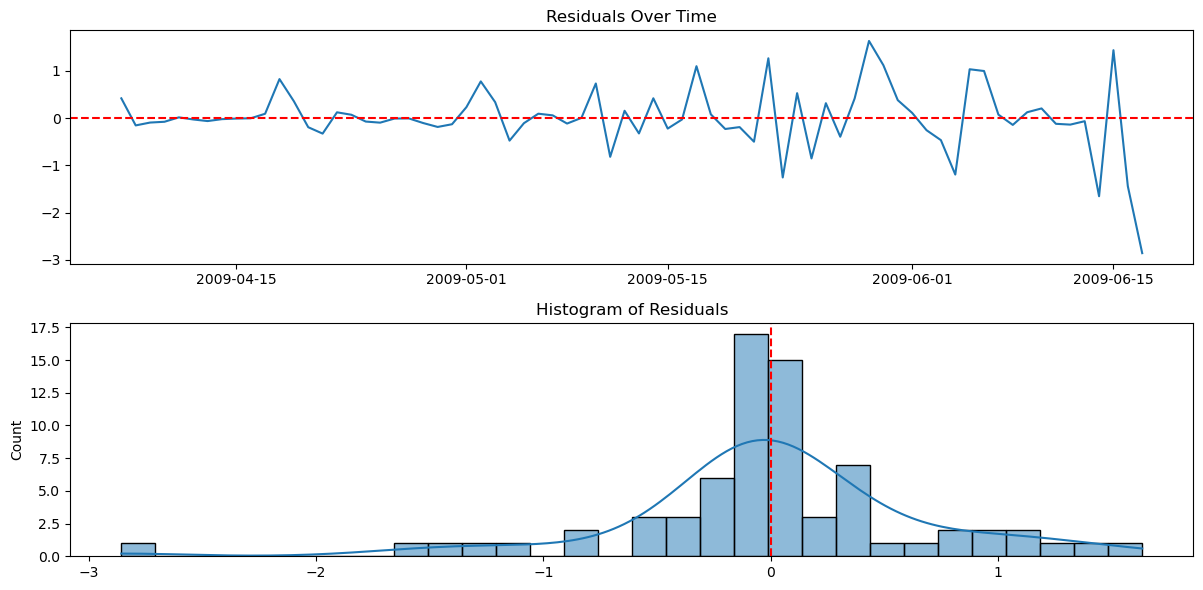

In [194]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title('Residuals Over Time')
plt.plot(residuals_arma )
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(212)
plt.title('Histogram of Residuals')
sns.histplot(residuals_arma, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

- The distribution of the residuals are still slightly left-skewed as observed in the histogram and by the shapiro test,
- The residuals also do not show patterns or trends, but still show values that are way bigger than 0. 

### ARIMA 

For the next model the parameters used is from the auto_arima, it does not require a lot of resources, it performs a stepwise approach, thus a starting point for the paramentes of the model. 

In [160]:
from pmdarima import auto_arima
import pmdarima as pm

# Fit the auto_arima model
model = pm.auto_arima(train_diff, start_p=0, start_q=0, max_p=8, max_d=1, max_q=8, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", trace=True)

# Print the best model's AIC
print(f'Best ARIMA model by auto_arima: {model} with AIC: {model.aic()}')


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=156.545, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=155.362, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=154.708, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=153.665, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=155.779, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=156.835, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=156.799, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 2.380 seconds
Best ARIMA model by auto_arima:  ARIMA(1,0,1)(0,0,0)[0]           with AIC: 153.66516584283954


- Based on the d=0 in all combinations means that the differencing made impact in the scores.
- The model will be evaluated by using the lowest AIC given (1,0,1).

                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -72.954
Date:                Tue, 14 Nov 2023   AIC                            153.908
Time:                        16:24:44   BIC                            163.015
Sample:                    04-07-2009   HQIC                           157.533
                         - 06-17-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0157      0.010      1.636      0.102      -0.003       0.035
ar.L1          0.5973      0.104      5.726      0.000       0.393       0.802
ma.L1         -0.9998      8.913     -0.112      0.9

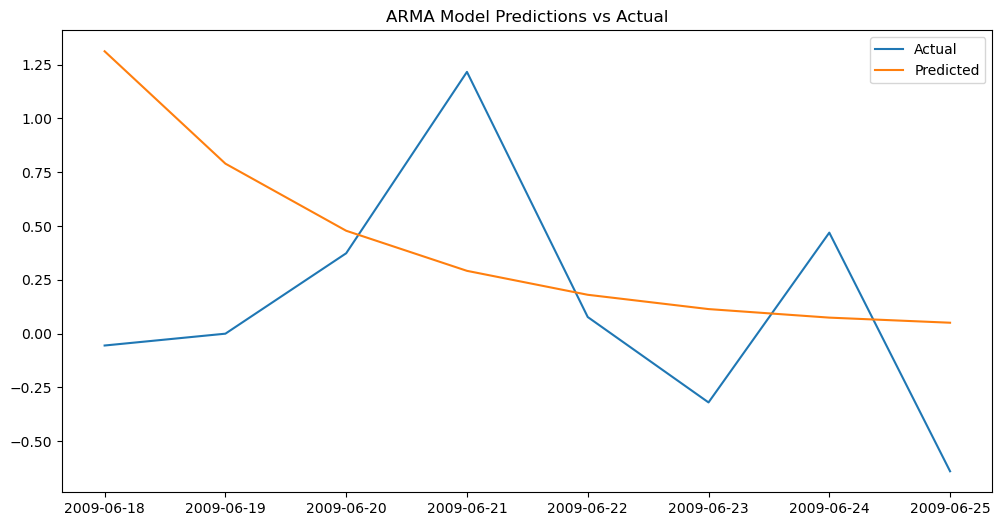

MSE: 0.5235919820975513
RMSE: 0.7235965603135157
MAE: 0.6009713318872851


In [165]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA(1,0,1) model based on auto_arima results.
model = ARIMA(train_diff, order=(1, 0, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train_diff), end=len(train_diff) + len(test_diff) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_diff, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test_diff, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_diff, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

- Due to the Stepwise algorithm, the results of the auto_arima might not be the optimal values for the ARIMA parameters. Thus, a grid search will be applied to go through all the combinations in a given range to provide the best values for (p, d, q) throught the AIC and MSE.

In [163]:
warnings.filterwarnings("ignore")

# Define the range of values for p, d, and q to try
p = range(0, 9)
d = range(0, 2)
q = range(0, 9)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# List to store a tuple of (AIC, (p, d, q)) for each model
aic_values = []

# Grid search over pdq combinations
for combination in pdq:
    try:
        model = ARIMA(train_diff, order=combination)
        results = model.fit()
        # Save the AIC and the (p, d, q) combination
        aic_values.append((results.aic, combination))
    except:
        continue

# Sort the list of AIC values in ascending order (lower AIC is better)
aic_values.sort(key=lambda x: x[0])

# Get the top 5 models with the lowest AIC values
top_5_models = aic_values[:5]

print("Top 5 ARIMA models by AIC:")
for aic, order in top_5_models:
    print(f'ARIMA{order} with AIC: {aic}')

Top 5 ARIMA models by AIC:
ARIMA(1, 0, 8) with AIC: 151.56225710947376
ARIMA(2, 0, 8) with AIC: 152.04972877283268
ARIMA(0, 0, 7) with AIC: 152.06942755725404
ARIMA(0, 0, 8) with AIC: 152.55086696111584
ARIMA(6, 0, 4) with AIC: 153.28006563685526


                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                 ARIMA(1, 0, 8)   Log Likelihood                 -64.781
Date:                Tue, 14 Nov 2023   AIC                            151.562
Time:                        16:58:58   BIC                            176.606
Sample:                    04-07-2009   HQIC                           161.532
                         - 06-17-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0281      0.070     -0.399      0.690      -0.166       0.110
ar.L1         -0.8171      0.144     -5.672      0.000      -1.099      -0.535
ma.L1          0.4361     18.734      0.023      0.9

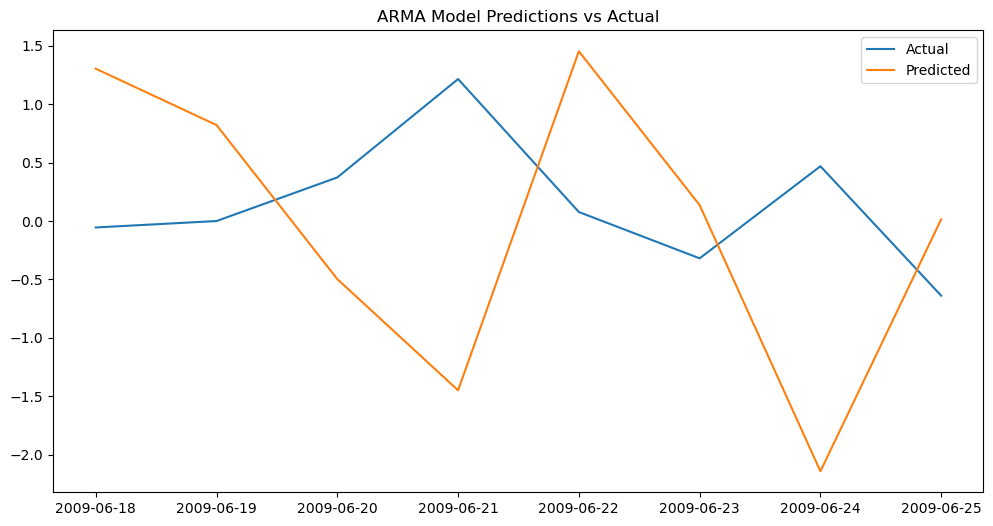

MSE: 2.468128868591533
RMSE: 1.5710279655663464
MAE: 1.3521592347450078


In [182]:
# Fit an ARIMA(1,0,8) model based on Grid search with AIC.
model = ARIMA(train_diff, order=(1, 0, 8))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train_diff), end=len(train_diff) + len(test_diff) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_diff, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test_diff, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_diff, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

In [166]:
warnings.filterwarnings("ignore")

# Define the range of values for p, d, and q to try
p = range(0, 9)
d = range(0, 3)
q = range(0, 9)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# List to store a tuple of (MSE, (p, d, q)) for each model
mse_values = []

# Grid search over pdq combinations
for combination in pdq:
    try:
        # Fit the ARIMA model
        model = ARIMA(train_diff, order=combination)
        results = model.fit()
        
        # Make predictions
        predictions = results.get_forecast(steps=len(test_diff))
        predicted_mean = predictions.predicted_mean
        
        # Calculate MSE
        mse = mean_squared_error(test_diff, predicted_mean)
        
        # Save the MSE and the (p, d, q) combination
        mse_values.append((mse, combination))
    except Exception as e:
        print(f'An error occurred for model ARIMA{combination}: {e}')

# Sort the list of MSE values in ascending order (lower MSE is better)
mse_values.sort(key=lambda x: x[0])

# Get the top 5 models with the lowest MSE values
top_5_models = mse_values[:5]

print("Top 5 ARIMA models by MSE:")
for mse, order in top_5_models:
    print(f'ARIMA{order} with MSE: {mse}')

Top 5 ARIMA models by MSE:
ARIMA(0, 0, 0) with MSE: 0.3036183147062904
ARIMA(0, 1, 1) with MSE: 0.3036250407157596
ARIMA(5, 1, 1) with MSE: 0.3173609276262925
ARIMA(5, 0, 0) with MSE: 0.33611595653083304
ARIMA(1, 1, 1) with MSE: 0.34122411020266463


                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   72
Model:                 ARIMA(5, 0, 1)   Log Likelihood                 -73.726
Date:                Tue, 14 Nov 2023   AIC                            163.453
Time:                        16:58:07   BIC                            181.666
Sample:                    04-07-2009   HQIC                           170.704
                         - 06-17-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.047     -0.019      0.985      -0.093       0.091
ar.L1          0.1599      0.595      0.269      0.788      -1.007       1.327
ar.L2         -0.0411      0.190     -0.216      0.8

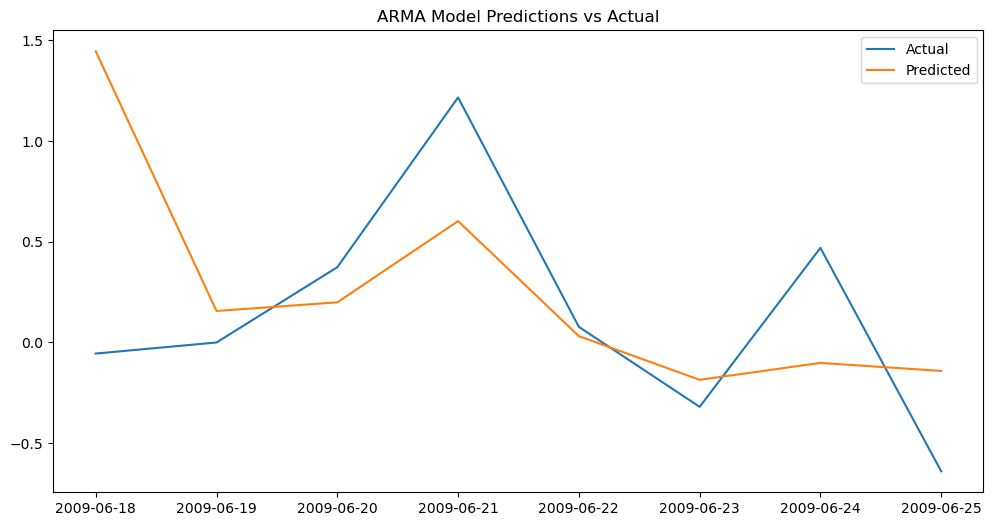

MSE: 0.4095626257562434
RMSE: 0.6399708007059723
MAE: 0.46172229083569877


In [180]:
# Fit an ARIMA(5,1,1) model based on Grid search with MSE.
model = ARIMA(train_diff, order=(5, 0, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train_diff), end=len(train_diff) + len(test_diff) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_diff, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test_diff, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_diff, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

#### ARIMA Residuals

In [183]:
# Get the residuals of the model for analysis.
residuals_arima = model_fit.resid

In [ ]:
# Shapiro-Wilk test for normality
shapiro_stat, shapiro_pvalue = stats.shapiro(residuals_arima)
print(f'Shapiro-Wilk test statistic: {shapiro_stat}')
print(f'Shapiro-Wilk test p-value: {shapiro_pvalue}')

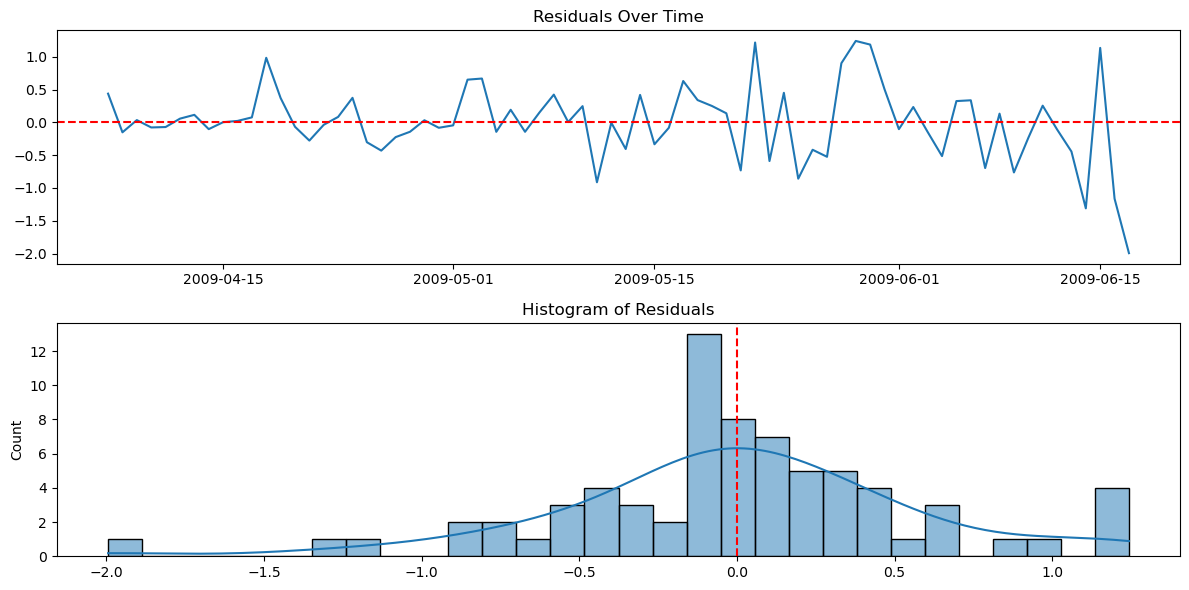

In [185]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title('Residuals Over Time')
plt.plot(residuals_arima)
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(212)
plt.title('Histogram of Residuals')
sns.histplot(residuals_arima, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

### Model Evaluation 

- The choice between the best model will be through the avaliation of metrics MSE and AIC as the most important. 
- The chosen parameters were based on ACF and PACF, Grid Search, manual attempts.

|       |    AR   |   ARMA  |  ARIMA  |
|-------|---------|---------|---------|
|  MSE  |  0.958  |  0.336  |add value|
|  RMSE |  0.978  |  0.579  |add value|
|  MAE  |  0.816  |  0.440  |add value|
|  AIC  |  153.99 |  162.46 |add value|
|  BIC  |  179.57 |  178.40 |add value|


The models ARMA and ARIMA presented a similiar performance, therefore between the three models tested both of the approaches can be considered to perform forecasting. Despite the AIC of the AR being lower than the others, by observing the line plot plus the lower MSE value will have a higher weight in the decision of the model. 


#### Sarima

In [200]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Fit the SARIMA model using auto_arima
model = pm.auto_arima(train_diff, start_p=1, start_q=1,
                      start_P=1, start_Q=1, max_p=3, max_q=3, max_P=3, max_Q=3,
                      m=7, seasonal=True,
                      stepwise=True, suppress_warnings=True, D=1, trace=True,
                      error_action='ignore',  # do not want to know if an order does not work
                      information_criterion='aic')  # set to 'aic' or 'bic' to select best model

# Print the summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=153.696, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=160.795, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=149.625, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=149.125, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=159.173, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=159.602, Time=0.11 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=150.850, Time=0.50 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=151.020, Time=1.22 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=149.175, Time=0.20 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=151.770, Time=0.94 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=153.016, Time=0.17 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=151.597, Time=0.43 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=151.080, Time=0.28 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=149.491, Time=0.20 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=151.8

In [201]:
# For daily data with weekly seasonality, s would be 7
s = 7

# Define the order and the seasonal order for the SARIMA model based on the auto_arima.
# These would be determined based on your data
order = (0, 0, 1)  # Non-seasonal order
seasonal_order = (0, 1, 1, s)  # Seasonal order

# Fit the SARIMA model
model = SARIMAX(train_diff, order=order, seasonal_order=seasonal_order)
results = model.fit(Disp=0)

# Print the summary
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03046D+00    |proj g|=  1.78401D-01

At iterate    5    f=  9.84470D-01    |proj g|=  3.40244D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   4.162D-06   9.844D-01
  F =  0.98442968501918793     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                     
Dep. Variable:                  power_sent

 This problem is unconstrained.


### Forecasting - 1 Week - 1 Month - 3 Months

In [ ]:
AAA

In [ ]:
df.unpersist()

In [ ]:
# Write the DataFrame to a CSV file in the local file system of the Spark driver node
df.write.csv('file:///home/hduser/Desktop/CA2/pro_tweets.csv', header=True)